# Introduction

1. code (compare cleaned to original)
2. train and test split (done)
3. dim red. and clustering (done)
4. SVMs (done)
5. logistic / random forests (!!!)



(should be ~200 words) (184 words)
For this machine learning project we were tasked to teach a binary classifier to identify if a given cancer cell could survive in a low oxygen environment (i.e. hypoxia) or if the cell needs oxygen to prosper (i.e. normoxia). We used data from an experiment which sequenced RNA from various breast cancer cells. Some cells came from a cell line that was in a low oxygen environment (~1%) and the other cells came from a cell line that was exposed to normal levels of oxygen. The aim for our binary classifier is to identify which genes (found in the RNA) can be attributed to the ability to survive in a low oxygen environment. Intuitively, if a gene were very present in cell from the hypoxia batch and not very present in the normal batch this could possibly mean that this gene helps cancer cells to survive even with very limited oxygen. From a medical point of view, this could help determine whether a certain cancer cell would need to be near arteries or if it could multiply even without a direct source of oxygen.

## Materials and Methods

We were given data derived utilizing Smart-Seq as a sequencing technique. The cell types included in the datasets were MCF7 and HCC1608. As features, we have various genes what were found when sequencing RNA from the various cells.

In [2]:
#Importing libraries
import sys
import sklearn
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
%matplotlib inline     
sns.set(color_codes=True)

---
---
# Data Exploration

We start this project with exploration of the metadata, followed by analysing aspects of the unfiltered data from the experiment. The aim of this section is to get a feel for the datasets we are working with. We will start off with visualizing the data through various graphs and plots, and we will eventually start cleaning and filtering the data in order to have clean and standardized data for our models to train on. 

## Metadata

The metadeta datasets give us generic information about the cells, such as their names and experiment, under what conditions they were analysed under and for how many hours, as well as others. These statistics are some general observations to help us understand these datasets better.

In [3]:
df_meta_HCC = pd.read_csv("raw_data/HCC1806_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)
df_meta_MCF = pd.read_csv("raw_data/MCF7_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)
print("Meta data dimensions for HCC1806:", df_meta_HCC.shape)
print("Meta data dimensions for MCF7:", df_meta_MCF.shape)

Meta data dimensions for HCC1806: (243, 8)
Meta data dimensions for MCF7: (383, 8)


Notice that most of the information provided by the metadata dataset is already contained in the name of the cell.

In [4]:
df_meta_HCC.head(10)

Cell Line  PCR Plate  Pos  \
Filename                                                                       
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....   HCC1806          1  A10   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...   HCC1806          1  A12   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...   HCC1806          1   A1   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...   HCC1806          1   A2   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...   HCC1806          1   A3   
output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sort...   HCC1806          1   A4   
output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.so...   HCC1806          1   A5   
output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sor...   HCC1806          1   A6   
output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.s...   HCC1806          1   A7   
output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.s...   HCC1806          1   A8   

                                                   Condition  Hours Cell name  \
Filename                                                                        
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....     Normo     24      S123   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...     Normo     24       S26   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...      Hypo     24       S97   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...      Hypo     24      S104   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...      Hypo     24        S4   
output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sort...      Hypo     24        S8   
output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.so...      Hypo     24      S108   
output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sor...      Hypo     24       S11   
output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.s...     Normo     24      S113   
output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.s...     Normo     24      S119   

                                                                 PreprocessingTag  \
Filename                                                                            
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sort...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.so...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sor...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.s...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.s...  Aligned.sortedByCoord.out.bam   

                                                    ProcessingComments  
Filename                                                                
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....  STAR,FeatureCounts  
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...  STAR,FeatureCounts  
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...  STAR,FeatureCounts  
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...  STAR,FeatureCounts  
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...  STAR,FeatureCounts  
output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sort...  STAR,FeatureCounts  
output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.so...  STAR,FeatureCounts  
output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sor...  STAR,FeatureCounts  
output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.s...  STAR,FeatureCounts  
output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.s...  STAR,FeatureCounts

In [5]:
df_meta_MCF.head(10)

Cell Line           Lane  \
Filename                                                                      
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....      MCF7  output.STAR.1   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....      MCF7  output.STAR.1   
output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord....      MCF7  output.STAR.1   
output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord....      MCF7  output.STAR.1   
output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord....      MCF7  output.STAR.1   
output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord....      MCF7  output.STAR.1   
output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord...      MCF7  output.STAR.1   

                                                    Pos Condition  Hours  \
Filename                                                                   
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...  A10      Hypo     72   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  A11      Hypo     72   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...  A12      Hypo     72   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....   A1      Norm     72   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....   A2      Norm     72   
output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord....   A3      Norm     72   
output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord....   A4      Norm     72   
output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord....   A5      Norm     72   
output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord....   A6      Norm     72   
output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord...   A7      Hypo     72   

                                                   Cell name  \
Filename                                                       
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       S28   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       S29   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       S30   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....        S1   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....        S2   
output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord....        S3   
output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord....        S4   
output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord....        S5   
output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord....        S6   
output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord...       S25   

                                                                 PreprocessingTag  \
Filename                                                                            
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord...  Aligned.sortedByCoord.out.bam   

                                                    ProcessingComments  
Filename                                                                
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...  STAR,FeatureCounts  
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  STAR,FeatureCounts  
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...  STAR,FeatureCounts  
output.STAR.1_A1_Norm_S1_Aligned.s

---
## Exploring the unfiltered data

We can now move to the more interesting and useful datasets. These are the unfiltered datasets in which we are given the crude experimental data. We will explore them and clean them up a bit before using them to train the models.

In [6]:
#HCC cell line
df_HCC_s_f = pd.read_csv("raw_data/HCC1806_SmartS_Filtered_Data.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_HCC_s_f_n_test = pd.read_csv("raw_data/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_HCC_s_f_n_train = pd.read_csv("raw_data/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_HCC_s_uf = pd.read_csv("raw_data/HCC1806_SmartS_Unfiltered_Data.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)

#MCF cell line
df_MCF_s_f = pd.read_csv("raw_data/MCF7_SmartS_Filtered_Data.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_MCF_s_f_n_test = pd.read_csv("raw_data/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_MCF_s_f_n_train = pd.read_csv("raw_data/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_MCF_s_uf = pd.read_csv("raw_data/MCF7_SmartS_Unfiltered_Data.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)



In this part, we will first analyse the unfiltered data through plots and graphs. After having understood our datasets better, which will help us identify some potential problems of the dataset and give some motivational arguments for the next steps.

In [7]:
print("Number of genes for unfiltered HCC1806 data: ", df_HCC_s_uf.shape[0])
print("Number of cells for unfiltered HCC1806 data: ", df_HCC_s_uf.shape[1])
df_HCC_s_uf.describe().T

Number of genes for unfiltered HCC1806 data:  23396
Number of cells for unfiltered HCC1806 data:  243


count        mean  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  23396.0   99.565695   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  23396.0  207.678278   
"output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.so...  23396.0    9.694734   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  23396.0  150.689007   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  23396.0   35.700504   
...                                                     ...         ...   
"output.STAR.PCRPlate4H10_Normoxia_S210_Aligned...  23396.0  104.740725   
"output.STAR.PCRPlate4H11_Normoxia_S214_Aligned...  23396.0   35.181569   
"output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.s...  23396.0  108.197940   
"output.STAR.PCRPlate4H7_Normoxia_S205_Aligned....  23396.0   37.279962   
"output.STAR.PCRPlate4H9_Normoxia_S236_Aligned....  23396.0   76.303855   

                                                           std  min  25%  50%  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  529.532443  0.0  0.0  0.0   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  981.107905  0.0  0.0  0.0   
"output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.so...   65.546050  0.0  0.0  0.0   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  976.936548  0.0  0.0  0.0   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  205.885369  0.0  0.0  0.0   
...                                                        ...  ...  ...  ...   
"output.STAR.PCRPlate4H10_Normoxia_S210_Aligned...  444.773045  0.0  0.0  2.0   
"output.STAR.PCRPlate4H11_Normoxia_S214_Aligned...  170.872090  0.0  0.0  0.0   
"output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.s...  589.082268  0.0  0.0  0.0   
"output.STAR.PCRPlate4H7_Normoxia_S205_Aligned....  181.398951  0.0  0.0  0.0   
"output.STAR.PCRPlate4H9_Normoxia_S236_Aligned....  369.090274  0.0  0.0  1.0   

                                                      75%      max  
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...   51.0  35477.0  
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  125.0  69068.0  
"output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.so...    5.0   6351.0  
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...   40.0  70206.0  
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...   22.0  17326.0  
...                                                   ...      ...  
"output.STAR.PCRPlate4H10_Normoxia_S210_Aligned...   76.0  33462.0  
"output.STAR.PCRPlate4H11_Normoxia_S214_Aligned...   24.0  15403.0  
"output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.s...   68.0  34478.0  
"output.STAR.PCRPlate4H7_Normoxia_S205_Aligned....   22.0  10921.0  
"output.STAR.PCRPlate4H9_Normoxia_S236_Aligned....   44.0  28532.0  

[243 rows x 8 columns]

In [8]:
print("Number of genes for unfiltered MCF7 data: ", df_MCF_s_uf.shape[0])
print("Number of cells for unfiltered MCF7 data: ", df_MCF_s_uf.shape[1])
df_MCF_s_uf.describe().T

Number of genes for unfiltered MCF7 data:  22934
Number of cells for unfiltered MCF7 data:  383


"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000            
mean                                           40.817651            
std                                           465.709940            
min                                             0.000000            
25%                                             0.000000            
50%                                             0.000000            
75%                                            17.000000            
max                                         46744.000000            

       "output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000            
mean                                            0.012253            
std                                             0.207726            
min                                             0.000000            
25%                                             0.000000            
50%                                             0.000000            
75%                                             0.000000            
max                                            14.000000            

       "output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000            
mean                                           86.442400            
std                                          1036.572689            
min                                             0.000000            
25%                                             0.000000            
50%                                             0.000000            
75%                                             5.000000            
max                                         82047.000000            

       "output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000          
mean                                            1.024636          
std                                             6.097362          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                           289.000000          

       "output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000          
mean                                           14.531351          
std                                           123.800530          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             7.000000          
max                                         10582.000000          

       "output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000          
mean                                           56.213613          
std                                           503.599145          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                            23.000000          
max                                         46856.000000          

       "output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000          
mean                                           75.397183          
std                                           430.471519          
min                                             0.000000     

For our datasets the features are the genes and each genes is identified with some gene codes. Here are some examples:

In [9]:
print("First 5 gene codes of HCC1806 data: \n", np.array(df_HCC_s_uf.index.values)[:5], "\n")
print("First 5 gene codes of MCF7 data:\n ", np.array(df_MCF_s_uf.index.values)[:5])

First 5 gene codes of HCC1806 data: 
 ['"WASH7P"' '"CICP27"' '"DDX11L17"' '"WASH9P"' '"OR4F29"'] 

First 5 gene codes of MCF7 data:
  ['"WASH7P"' '"MIR6859-1"' '"WASH9P"' '"OR4F29"' '"MTND1P23"']


As our examples we have the cells that have been sequenced. Here are some examples:

In [10]:
print("First 5 cells of HCC1806 data: \n", np.array(df_HCC_s_uf.columns)[:5], "\n")
print("First 5 cells of MCF7 data:\n ", np.array(df_MCF_s_uf.columns)[:5])

First 5 cells of HCC1806 data: 
 ['"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"'
 '"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"'
 '"output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"'
 '"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"'
 '"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam"'] 

First 5 cells of MCF7 data:
  ['"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"'
 '"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"'
 '"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"'
 '"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"'
 '"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"']


---
## Investigating the genes

Let's now focus on the genes. We are going to present some graphs for us to understand how the genes are distribiuted. As a  first step we plot some violin graphs. They are statistical graphs that take a cell as input and visualize how many genes take a specific value in that cell's column.

However, there is somewhat of a drawback to this method: the number of genes sequenced for each cell can be any positive integer between 0 and over 50 000. Therefore, it is very rare that many genes occur exactly the same amount of times. The result is that there are a lot of genes that occur 0 times, and all the other genes are spread out between 0 and the maximum. One observation we can make is that the number of gene occurences tend to accumulate around lower values and only a few genes have very large number of occurences.

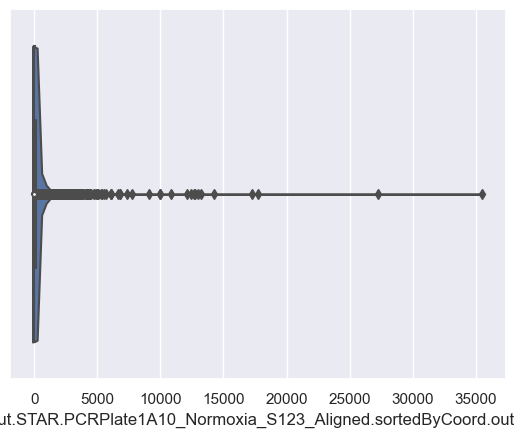

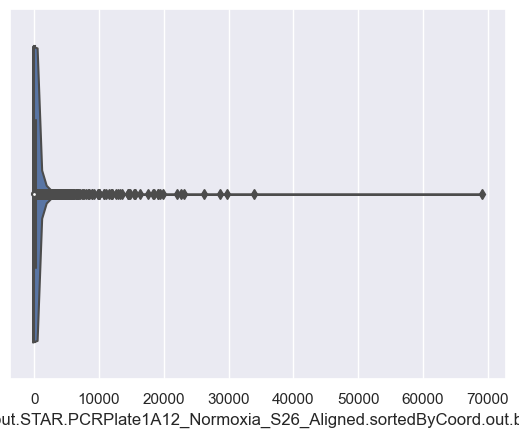

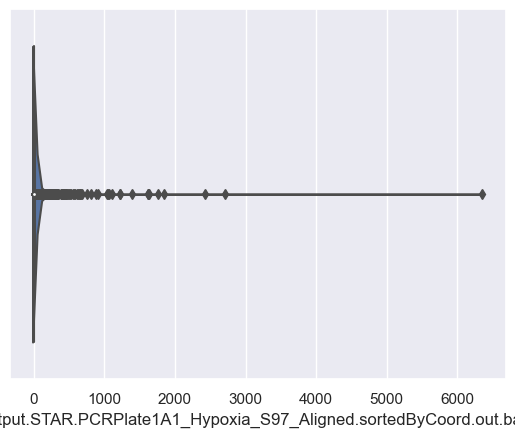

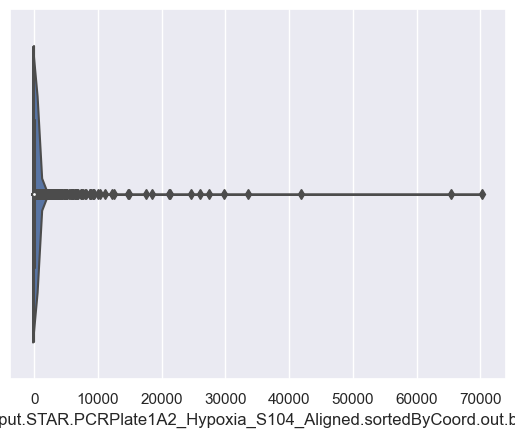

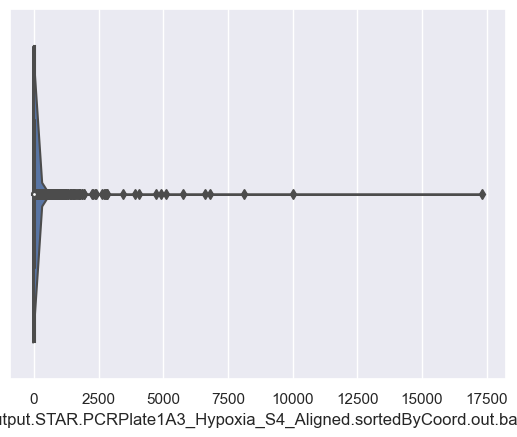

In [11]:
#Function to crate the violin plots
cnames_MCF = list(df_MCF_s_uf.columns)
cnames_HCC = list(df_HCC_s_uf.columns)
def violin(df, n=5):
    cnames = list(df.columns)
    for i in range(n):
        #We show the violin graphs of the first n cells
        sns.boxplot(x=df[cnames[i]])
        sns.violinplot(x=df[cnames[i]])
        plt.show()

#Violin plots for the HCC1806 dataset  
violin(df_HCC_s_uf)

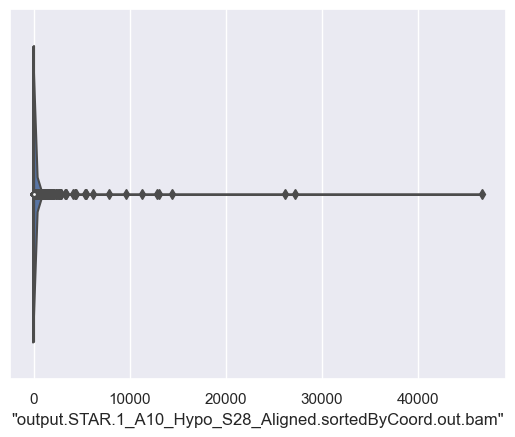

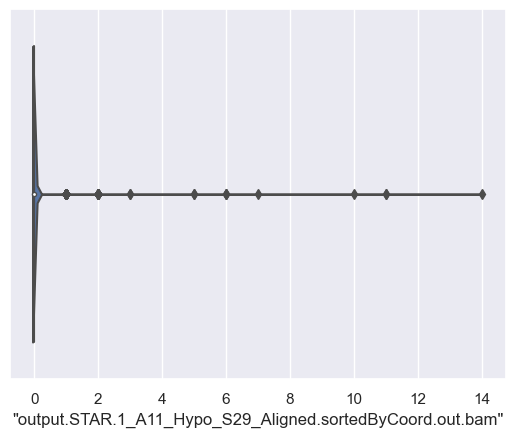

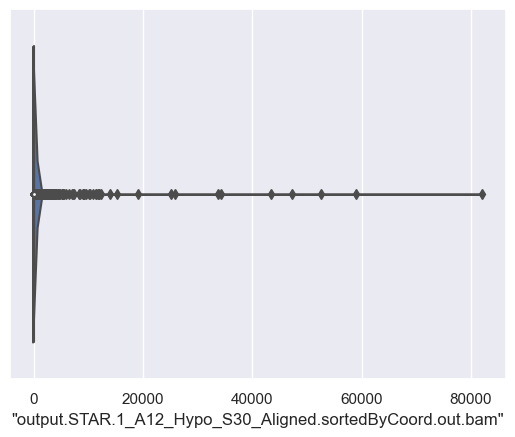

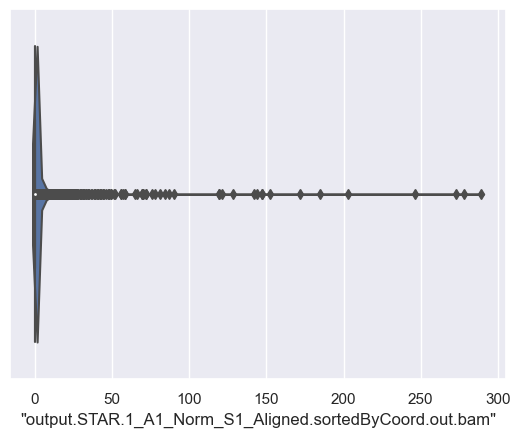

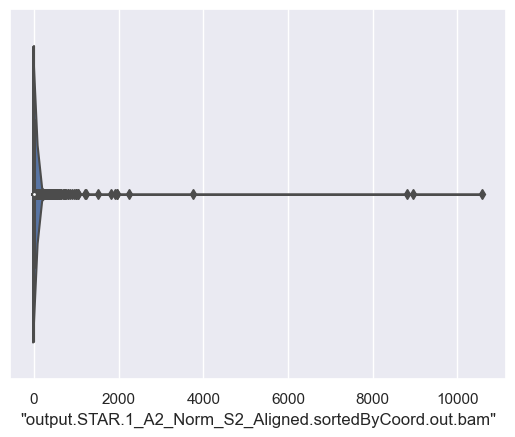

In [12]:
#Violin plots for the MCF7 data set
violin(df_MCF_s_uf)

We can also compare the violin plots for 50 cells directly. For the reasons mentioned above, these plots show us the range of gene occurences for some columns of our dataset. However, as we have seen, the points on the violin graphs have a tendency to be more present around lower values.
We also (temporarily) randomly mix around the columns so that we are not allways graphing the same 50 or so cells.

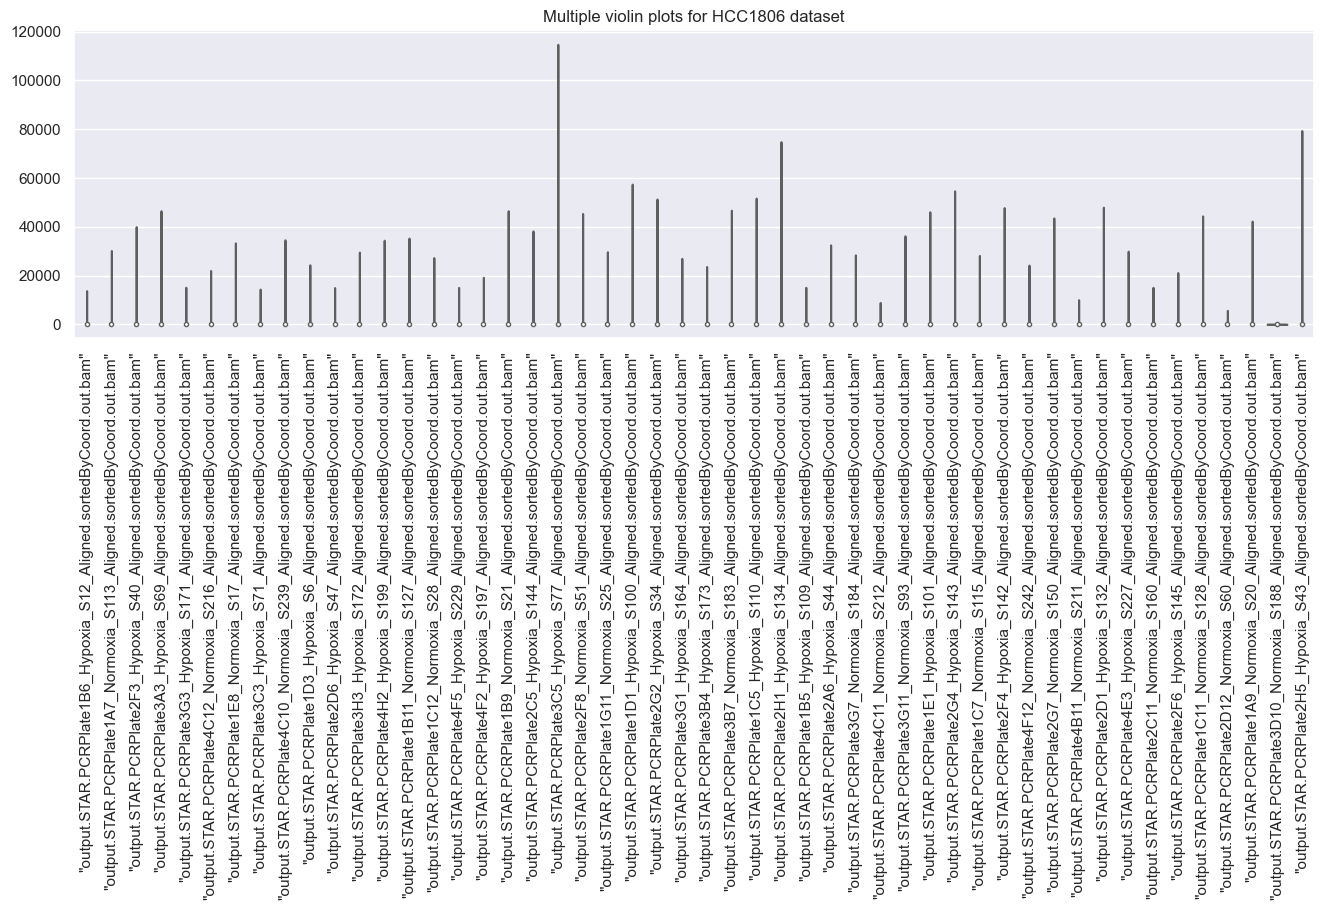

In [82]:
#Comparing violin plots for the HCC1806 dataset
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_HCC_s_uf.sample(frac=1, axis = 'columns').iloc[:,:50],palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title("Multiple violin plots for HCC1806 dataset")
plt.show()

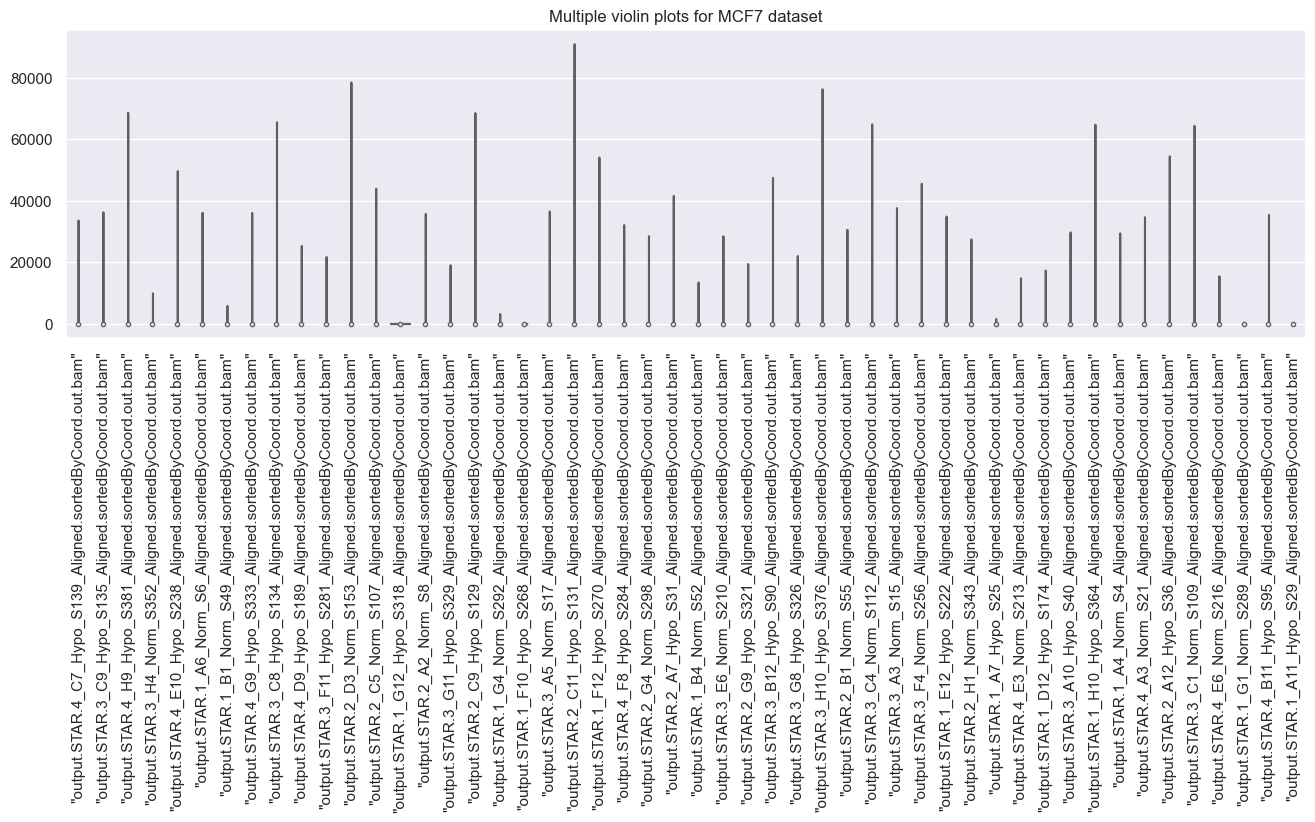

In [83]:
#Comparing violin plots for the MCF7 dataset
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_MCF_s_uf.sample(frac=1, axis = 'columns').iloc[:,:50],palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title("Multiple violin plots for MCF7 dataset")
plt.show()

We would like to show the distribution of some genes. To avoid choosing genes a large amount of zeros we create a simple function which returns the genes with the highest number of non zero entries.

In [104]:
#Function which returns the n genes with the largest number of non-zero entries 
def best_genes(df, n):
    return ((df != 0).sum(axis=1).nlargest(n)).index.values


We can next plot some graphs which illustrate the distribution of our 20 chosen genes. With these we can see how he chosen genes are distributed. As expected a lot of the genes have a spike close to 0 and then falls as we get further from 0.

Please be warned that the scales of the histogram do vary across genes!

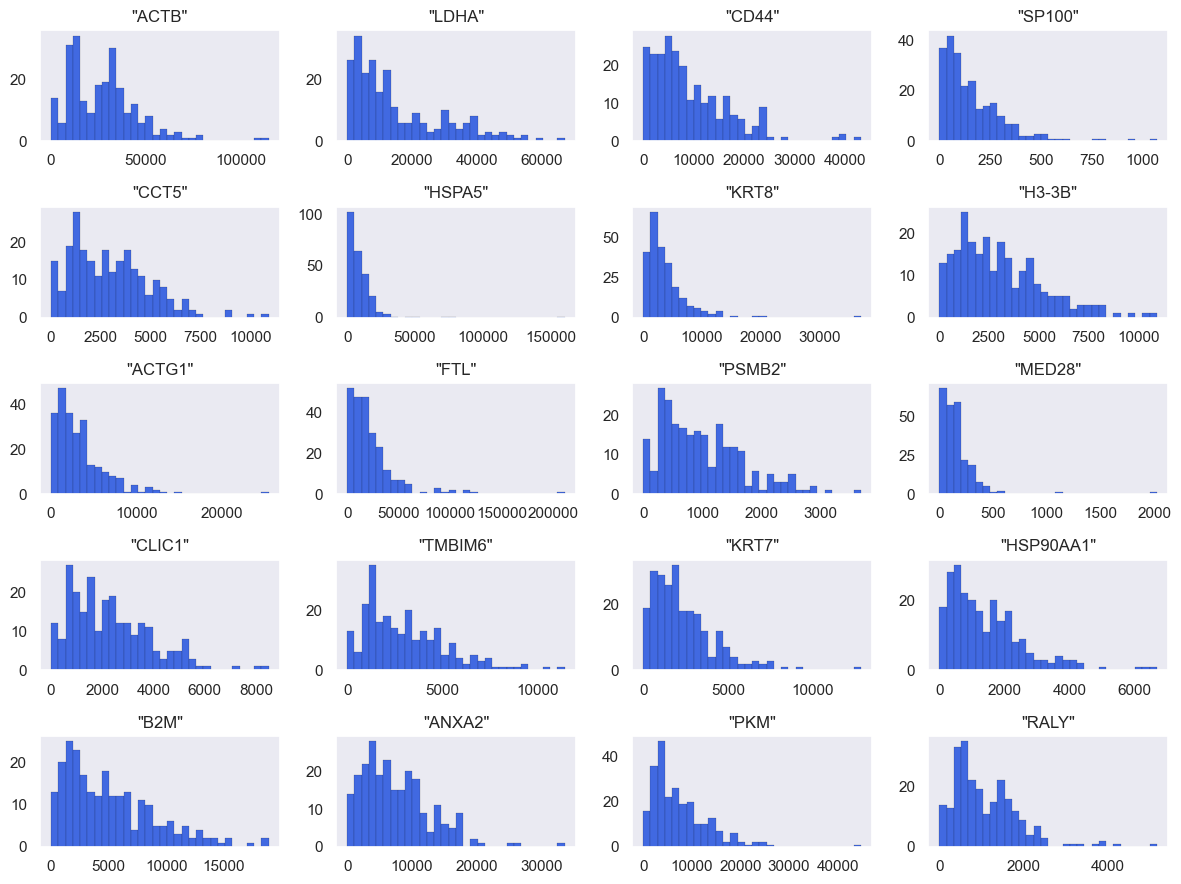

In [113]:
#Histograms for HCC1806
small_MCF = df_HCC_s_uf.loc[best_genes(df_HCC_s_uf, 20)].T
small_MCF.hist(
    bins=30, 
    figsize=(12,9), 
    color="royalblue",
    ec="black", 
    lw=0.1, 
    grid=False,
)
plt.tight_layout()
plt.show()

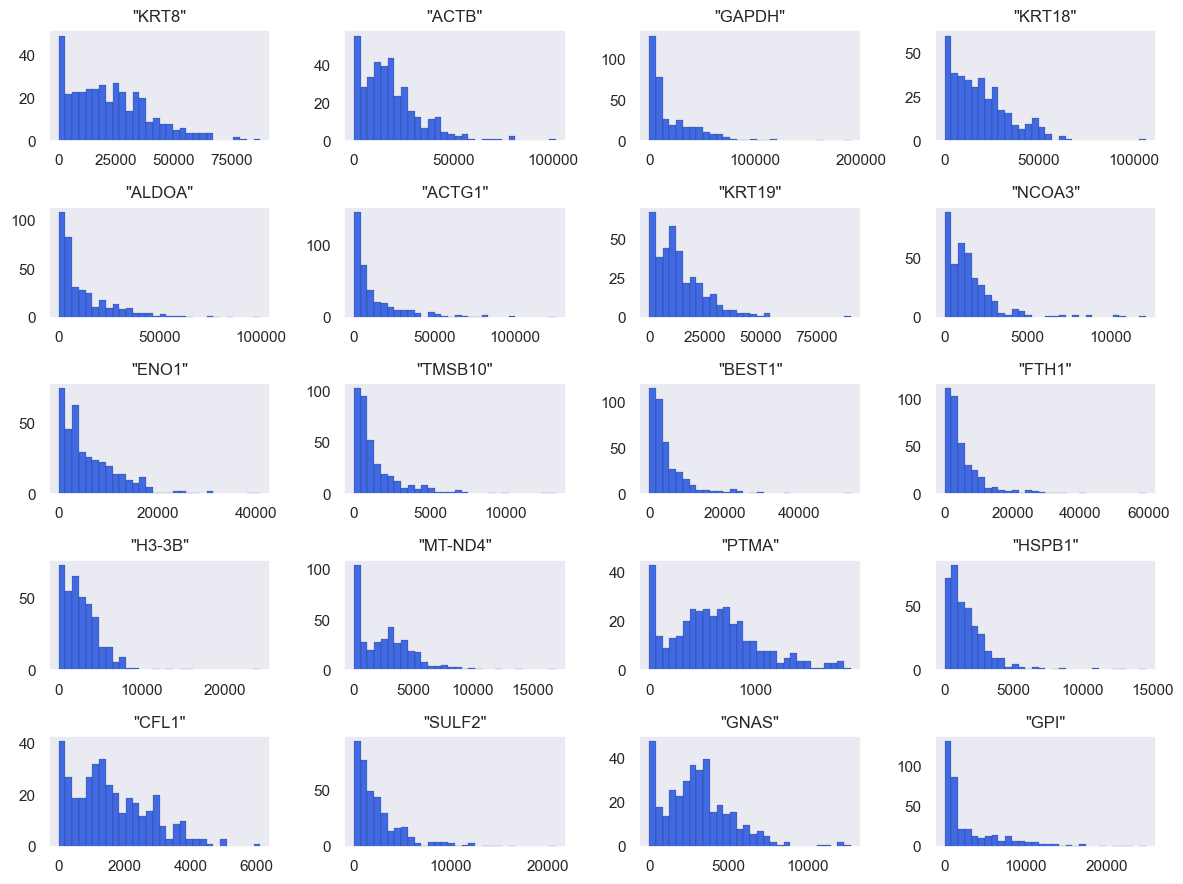

In [114]:
#Histograms for MCF7
small_MCF = df_MCF_s_uf.loc[best_genes(df_MCF_s_uf, 20)].T
small_MCF.hist(
    bins=30, 
    figsize=(12,9), 
    color="royalblue",
    ec="black", 
    lw=0.1, 
    grid=False,
)
plt.tight_layout()
plt.show()

Another way of illustrating the distribution of the genes is to show some box plots.

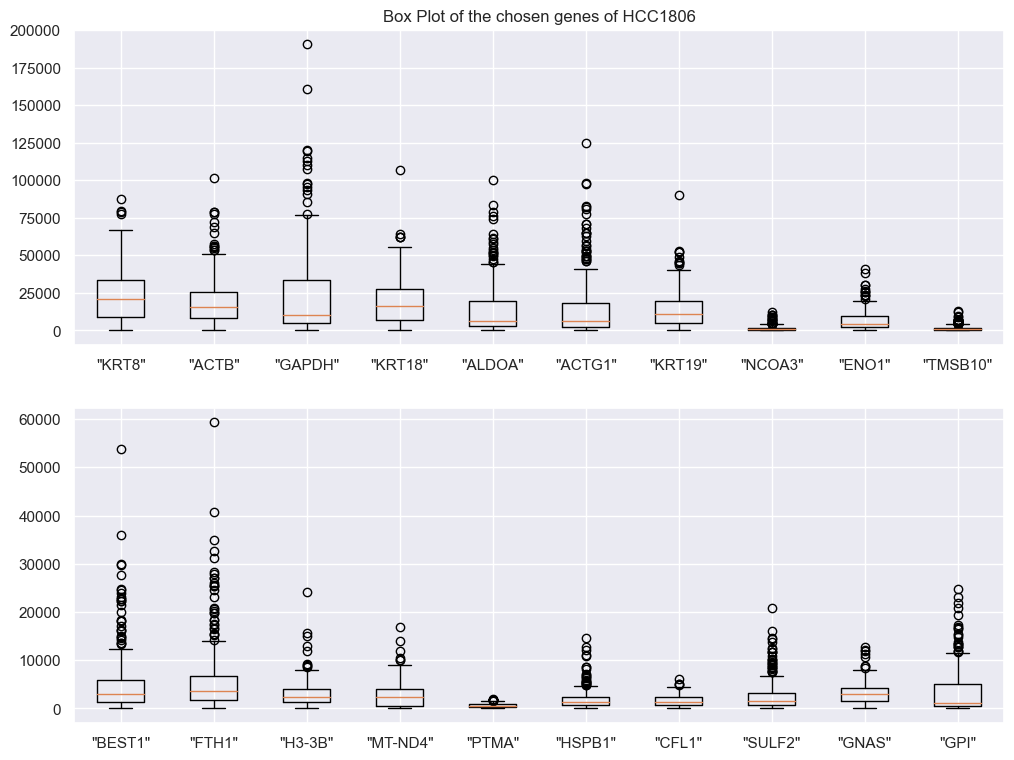

In [122]:
#Box plots for HCC1806
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
ax1.boxplot(small_MCF[small_MCF.columns[:10]], labels=small_MCF.columns[:10])
ax2.boxplot(small_MCF[small_MCF.columns[10:]], labels=small_MCF.columns[10:])
ax1.set_title("Box Plot of the chosen genes of HCC1806")
plt.show()

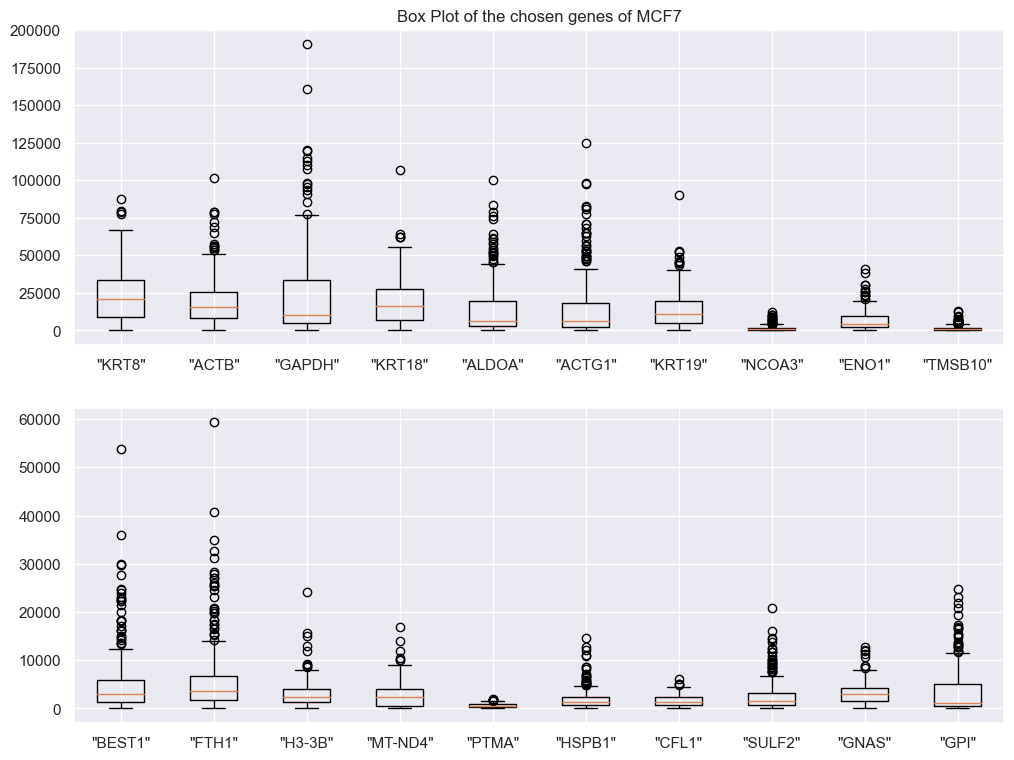

In [121]:
#Box plots for MCF7
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
ax1.boxplot(small_MCF[small_MCF.columns[:10]], labels=small_MCF.columns[:10])
ax2.boxplot(small_MCF[small_MCF.columns[10:]], labels=small_MCF.columns[10:])
ax1.set_title("Box Plot of the chosen genes of MCF7")
plt.show()

Notice that we have a lot of points are very far from the median and in some cases even very far the the wiskers of the boxplots! It might be tempting to call these outliers however in many case these points are instances in which a gene has been found many times and if we were to eliminate these points we will lose a lot of information! This is exactly the delemma we face in the outlier section.

We next decided to plot the 50 genes with the largest number of occurences over all cells. In doing so, we get to see if the dataset contains some genes that appear a lot and some that never appear or if the apperences are more evenly spred.
For both datasets we see that after the initail spike with very common genes the bar graph smooths out. We also calculated how many total gene occurences we are neglecting by plotting only the 50 most common genes, and we realize that the remaining genes still represent a very large amount of gene detections(which we expect because of the large amount of genes in the datasets).

Percentage of occurences not present in the graph: 83.75%


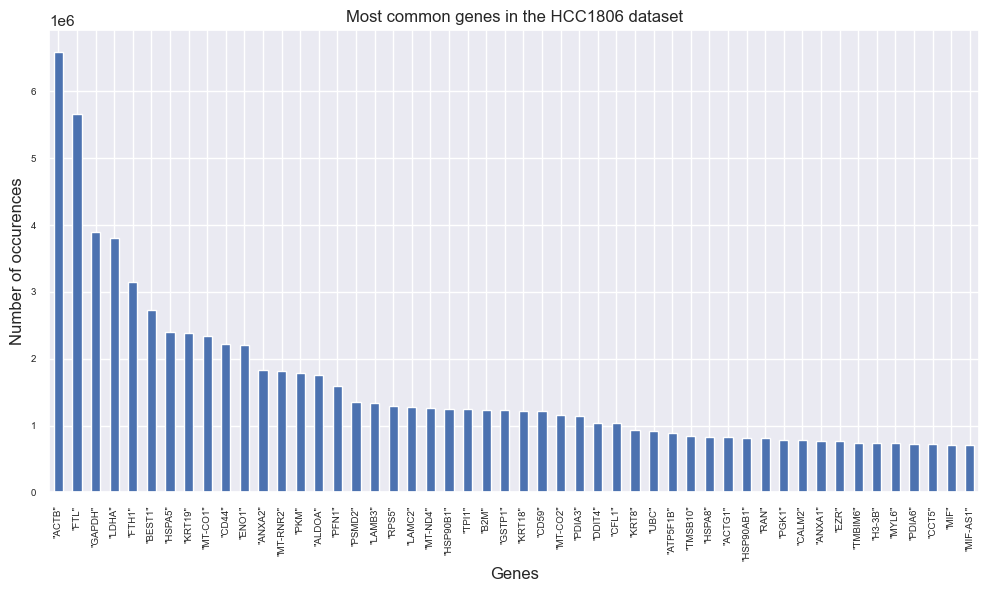

In [86]:
#Representing how often a specific gene is found in a cell (I picked the 50 largest ones)
largest_HCC = df_HCC_s_uf.sum(axis='columns').nlargest(50)

#Calculating the remaining number of occurences
remaining_HCC = df_HCC_s_uf.sum(axis='columns').sum() - df_HCC_s_uf.sum(axis='columns')[largest_HCC.index.values].sum()

#We print the percentage of occurences not represented in the graph
print("Percentage of occurences not present in the graph:", 
      f"{round(remaining_HCC/df_HCC_s_uf.sum(axis='columns').sum() * 100, 2)}%")
plt.figure(figsize=(12,6))
ax = largest_HCC.plot.bar(stacked = True, fontsize = 7)
plt.xlabel('Genes')
plt.ylabel('Number of occurences')
plt.title("Most common genes in the HCC1806 dataset")
plt.show()

Percentage of occurences not present in the graph: 76.14%


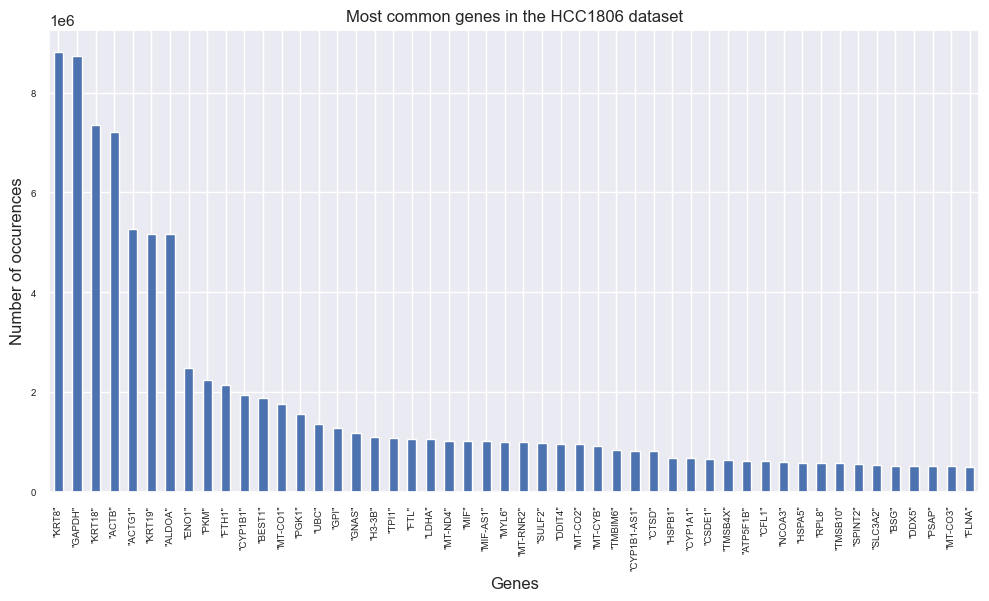

In [87]:
#Representing how often a specific gene is found in a cell (I picked the 50 largest ones)
largest_MCF = df_MCF_s_uf.sum(axis='columns').nlargest(50)

#Calculating the remaining number of occurences
remaining_MCF = df_MCF_s_uf.sum(axis='columns').sum() - df_MCF_s_uf.sum(axis='columns')[largest_MCF.index.values].sum()

#We print the percentage of occurences not represented in the graph
print("Percentage of occurences not present in the graph:", 
      f"{round(remaining_MCF/df_MCF_s_uf.sum(axis='columns').sum() * 100, 2)}%")
plt.figure(figsize=(12,6))
ax = largest_MCF.plot.bar(stacked = True, fontsize = 7)
plt.xlabel('Genes')
plt.ylabel('Number of occurences')
plt.title("Most common genes in the MCF7 dataset")
plt.show()

In both cases the bar graph drops down quite quickly which leads us to believe that many genes occure very rearly and most of the information is given by a small fraction of genes. In fact when we train our model we will only use the information given by the 3000 most informative genes.

For each data set we differenciate between cells from the hypoxia experiment and cells from the normoxia experiment. We then create two sub datasets one of which contains all the columns corresponding to hypoxia cells and the other containing only columns of normoxia cells.

In [17]:
#Function that retruns lists of all cells that were part of the hypoxia and normoxia groups
def hypo_and_norm(df):
    hypo = []
    norm = []
    for cell in df.columns:
        if "Hypo" in cell.split("_") or "Hypoxia" in cell.split("_"):
            hypo.append(cell)
        elif "Norm" in cell.split("_") or "Normoxia" in cell.split("_"):
            norm.append(cell)
        else:
            print("Unkown:", cell)
    return (hypo, norm)

#Data sets that contain only hypoxia cells
df_MCF_hypo = df_MCF_s_uf[hypo_and_norm(df_MCF_s_uf)[0]]
df_HCC_hypo = df_HCC_s_uf[hypo_and_norm(df_HCC_s_uf)[0]]

#Data sets that contain only normoxia cells
df_MCF_norm = df_MCF_s_uf[hypo_and_norm(df_MCF_s_uf)[1]]
df_HCC_norm = df_HCC_s_uf[hypo_and_norm(df_HCC_s_uf)[1]]

#How many hypoxia and how many normoxia are in each dataset
print("Number of cells exposed to hypoxia for HCC1806 data: ", len(hypo_and_norm(df_HCC_s_uf)[0])) 
print("Number of cells exposed to normoxia for HCC1806 data: ", len(hypo_and_norm(df_HCC_s_uf)[1]))

print("Number of cells exposed to hypoxia for MCF7 data: ", len(hypo_and_norm(df_MCF_s_uf)[0])) 
print("Number of cells exposed to normoxia for MCF7 data: ", len(hypo_and_norm(df_MCF_s_uf)[1]))


Number of cells exposed to hypoxia for HCC1806 data:  126
Number of cells exposed to normoxia for HCC1806 data:  117
Number of cells exposed to hypoxia for MCF data:  191
Number of cells exposed to normoxia for MCF data:  192


Luckily for both datasets the amount of examples from the hypoxia enviorment and the normoxia enviorment are more or less balanced. This helps us as the models will have an even exposure to both types of enviorments reducing the likelihood of any bias towards one of the labels.

In view of our final goal of this report we thought that it could be insightful to represent genes whose total occurences vary the most between the two types of enviorment.
To illustrate this did the following for both datasets:
First we took only the colums with hypoxia cells and summed them so we could see how often each gene was found in the cells that had little oxygen.
We did the same for the Normoxia cells and we took the differences (in abs) between the gene occurences in normoxia cells and hypoxia cells. We presented the 20 genes that had the largest differences.
The idea of this represention is to see if some genes are obviously more present in hypoxia cells. If this was the case, we would be lead to believe that this gene may play a role in the survival of a cell with no oxygen. Similarly if a gene was very present only in normoxia cells then this gene might not be useful in a hypoxia enviorment(or it might even be degenerous).
Please note that we cannot strongly conclude anything from the following graphs, differences might also be due to some sampling bias.

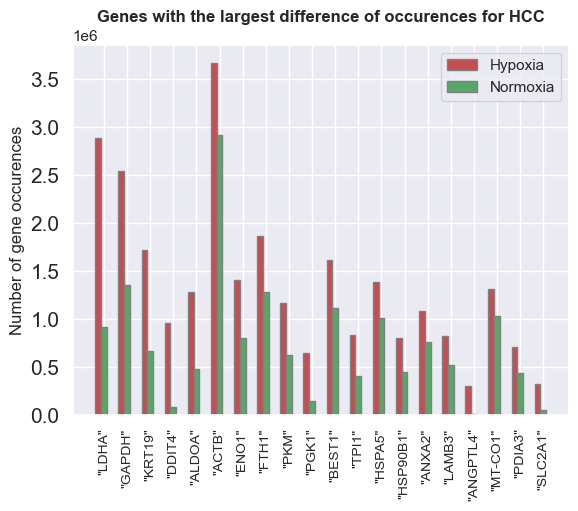

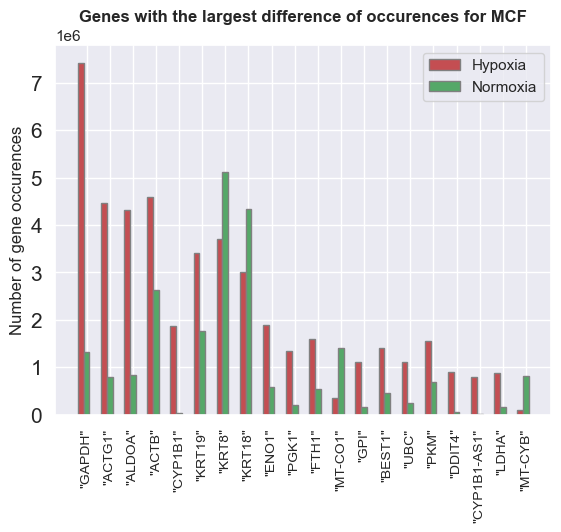

array(['"GAPDH"', '"ACTG1"', '"ALDOA"', '"ACTB"', '"CYP1B1"', '"KRT19"',
       '"KRT8"', '"KRT18"', '"ENO1"', '"PGK1"', '"FTH1"', '"MT-CO1"',
       '"GPI"', '"BEST1"', '"UBC"', '"PKM"', '"DDIT4"', '"CYP1B1-AS1"',
       '"LDHA"', '"MT-CYB"'], dtype=object)

In [18]:
def hypo_vs_norm(df_hypo, df_norm,n=20, width = 0.25, title="Hypoxia vs Normoxia", type = 'l'):
    #Get a list of the total occurences of each gene
    genes_norm = df_norm.sum(axis='columns')
    genes_hypo = df_hypo.sum(axis='columns')

    #Find the genes with the largest (type == 'l') or smallest (type == 's') difference of occurences 
    # between hypo cells and norm cells
    if type == 'l':
        diffs = (genes_hypo.sub(genes_norm)).apply(abs).nlargest(n)
    elif type == 's':
        diffs = (genes_hypo.sub(genes_norm)).apply(abs).nsmallest(n)
    else:
        raise ValueError("Wrong type")
    
    diffs_genes = diffs.index.values

    #Bar graph with gene occurences in hypo vs norm
    plt.bar(np.arange(len(genes_hypo[diffs_genes])), 
            genes_hypo[diffs_genes].tolist(), 
            color ='r', 
            width = width,
            edgecolor ='grey', 
            label ='Hypoxia')

    plt.bar([x + width for x in np.arange(len(genes_hypo[diffs_genes]))],
            genes_norm[diffs_genes].tolist(), 
            color ='g', 
            width = width,
            edgecolor ='grey', 
            label ='Normoxia')

    plt.xticks([r + width for r in range(len(diffs_genes))],
            diffs_genes,
            rotation=90,
            fontsize=10)
    plt.title(title, weight='bold')
    plt.yticks(fontsize = 15)
    plt.ylabel("Number of gene occurences")
    plt.legend()
    plt.show()
    return diffs_genes


hypo_vs_norm(df_HCC_hypo, df_HCC_norm, title = "Genes with the largest difference of occurences for HCC1806")
hypo_vs_norm(df_MCF_hypo, df_MCF_norm, title = "Genes with the largest difference of occurences for MCF7")


A similar reasoning as above is to see which genes have the smallest difference in occurences between normoxia cells and hypoxia cells. This might give us an idea of which are the so called housekeeping genes. These genes are need for the basic function of the cells and so shouldn't really change between normoxia and hypoxia cells.

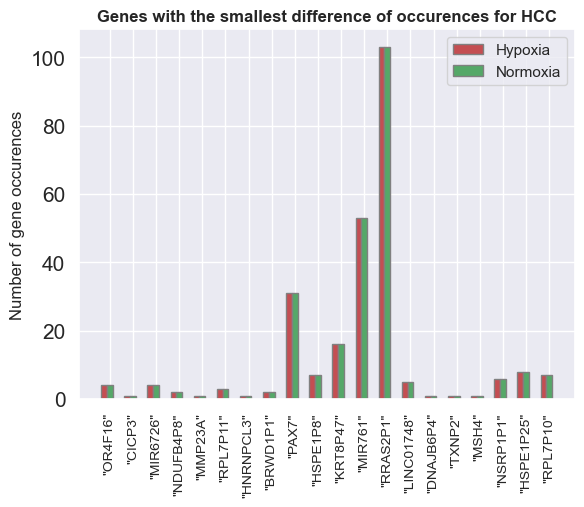

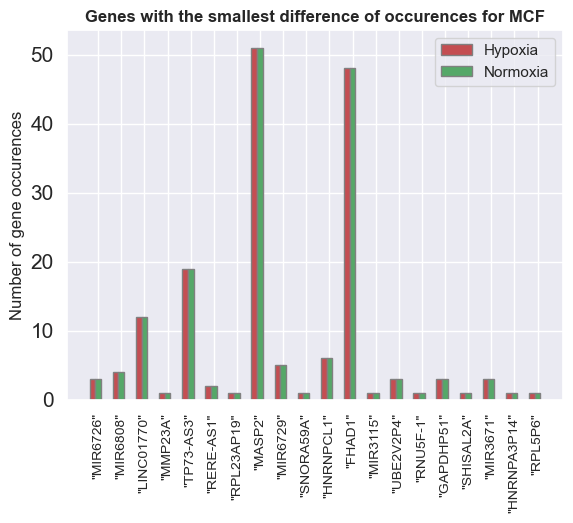

array(['"MIR6726"', '"MIR6808"', '"LINC01770"', '"MMP23A"', '"TP73-AS3"',
       '"RERE-AS1"', '"RPL23AP19"', '"MASP2"', '"MIR6729"', '"SNORA59A"',
       '"HNRNPCL1"', '"FHAD1"', '"MIR3115"', '"UBE2V2P4"', '"RNU5F-1"',
       '"GAPDHP51"', '"SHISAL2A"', '"MIR3671"', '"HNRNPA3P14"',
       '"RPL5P6"'], dtype=object)

In [19]:
hypo_vs_norm(df_HCC_hypo, df_HCC_norm, title = "Genes with the smallest difference of occurences for HCC1806", type = 's')
hypo_vs_norm(df_MCF_hypo, df_MCF_norm, title = "Genes with the smallest difference of occurences for MCF7", type = 's')


---
---
# Data cleaning
Now that we have analysed the datasets, we can move on to data cleaning. In this process, we can identify and correct any potential issues that could arise when analysing our dataset. We had already foreshadowed this while checking for missing values, but since there were none we did not have to change the dataset. 

## Missing values
One of the first things to check is whether there are missing values. In these datasets, there are none: this is due to the fact that if a gene was not found in a specific cell, the value was set to 0, eliminating the possibility of NA. We do notice, however, that many rows contain a large amount of zeros, which is a problem which we will discuss further on.
Since there are no missing values, we can proceed by doing some preliminary analysis of our datasets.

In [20]:
#Creating a function which returns the number of missing values given a data set
def missing(df):
    miss = False
    if df.isnull().stack().sum() != 0:
        miss = True
        return str(df.isnull().stack().sum())
    if not miss:
        return "No missing values"

print("Number of missing values for the HCC1806 data: ", missing(df_HCC_s_uf))
print("Number of missing values for the MCF7 data: ", missing(df_MCF_s_uf))

Number of missing values for the HCC1806 data:  No missing values
Number of missing values for the MCF7 data:  No missing values


As mentioned previously, there are many zero values, hence some genes occur rarely. This means that we are dealing with a sparse dataset, and it has to be taken into account throughout this analysis.

In [21]:
#Function that returns percentage of entries which are zero given a data frame
def frac_zeros(df, n=20):
    return (((df == 0).sum(axis=1).sum())/(df.shape[0] * df.shape[1])) * 100


print("Percentage of entries which are zero in the HCC1806 dataset: ", f"{round(frac_zeros(df_HCC_s_uf), 2)}%")
print("Percentage of entries which are zero in the MCF7 dataset: ", f"{round(frac_zeros(df_MCF_s_uf), 2)}%")

Percentage of entries which are zero in the HCC1806 dataset:  55.85%
Percentage of entries which are zero in the MCF7 dataset:  60.22%


---
## Duplicate rows

In [22]:
def duplicate_rows(df, all_cells = False, shape = False):
    if shape:
        print("Number of duplicate rows: ", df[df.duplicated(keep=False)].shape)
    if all_cells:
        print("Duplicate rows: ", df[df.duplicated(keep=False)])
    return df[df.duplicated(keep=False)]

duplicate_rows(df_MCF_s_uf)

"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"  \
"SHISAL2A"                                                         0            
"IL12RB2"                                                          0            
"S1PR1"                                                            0            
"CD84"                                                             0            
"GNLY"                                                             0            
"FAR2P3"                                                           0            
"KLF2P3"                                                           0            
"PABPC1P2"                                                         0            
"UGT1A8"                                                           0            
"UGT1A9"                                                           0            
"SLC22A14"                                                         0            
"COQ10BP2"                                                         0            
"PANDAR"                                                           0            
"LAP3P2"                                                           0            
"RPL22P16"                                                         0            
"GALNT17"                                                          0            
"PON1"                                                             0            
"HTR5A"                                                            0            
"SNORA36A"                                                         0            
"MIR664B"                                                          0            
"CSMD1"                                                            0            
"KCNS2"                                                            0            
"MIR548AA1"                                                        0            
"MIR548D1"                                                         0            
"MTCO2P11"                                                         0            
"CLCN3P1"                                                          0            
"SUGT1P4-STRA6LP"                                                  0            
"STRA6LP"                                                          0            
"MUC6"                                                             0            
"VSTM4"                                                            0            
"LINC00856"                                                        0            
"LINC00595"                                                        0            
"CACYBPP1"                                                         0            
"LINC00477"                                                        0            
"KNOP1P1"                                                          0            
"WDR95P"                                                           0            
"MIR20A"                                                           0            
"MIR19B1"                                                          0            
"RPL21P5"                                                          0            
"RNU6-539P"                                                        0            
"SNRPN"                                                            0            
"SNURF"                                                            0            
"RBFOX1"                                                           0            
"LINC02183"                                                        0            
"MT1M"                                                             0            
"ASPA"                                                             0            
"BCL6B"                                                            0            
"CCL3L3"                                                           0            
"CCL3L1"                                          

In [23]:
duplicate_rows(df_MCF_s_uf, True, True)

Number of duplicate rows:  (56, 383)
Duplicate rows:                     "output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"  \
"SHISAL2A"                                                         0            
"IL12RB2"                                                          0            
"S1PR1"                                                            0            
"CD84"                                                             0            
"GNLY"                                                             0            
"FAR2P3"                                                           0            
"KLF2P3"                                                           0            
"PABPC1P2"                                                         0            
"UGT1A8"                                                           0            
"UGT1A9"                                                           0            
"SLC22A14"                                             

"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"  \
"SHISAL2A"                                                         0            
"IL12RB2"                                                          0            
"S1PR1"                                                            0            
"CD84"                                                             0            
"GNLY"                                                             0            
"FAR2P3"                                                           0            
"KLF2P3"                                                           0            
"PABPC1P2"                                                         0            
"UGT1A8"                                                           0            
"UGT1A9"                                                           0            
"SLC22A14"                                                         0            
"COQ10BP2"                                                         0            
"PANDAR"                                                           0            
"LAP3P2"                                                           0            
"RPL22P16"                                                         0            
"GALNT17"                                                          0            
"PON1"                                                             0            
"HTR5A"                                                            0            
"SNORA36A"                                                         0            
"MIR664B"                                                          0            
"CSMD1"                                                            0            
"KCNS2"                                                            0            
"MIR548AA1"                                                        0            
"MIR548D1"                                                         0            
"MTCO2P11"                                                         0            
"CLCN3P1"                                                          0            
"SUGT1P4-STRA6LP"                                                  0            
"STRA6LP"                                                          0            
"MUC6"                                                             0            
"VSTM4"                                                            0            
"LINC00856"                                                        0            
"LINC00595"                                                        0            
"CACYBPP1"                                                         0            
"LINC00477"                                                        0            
"KNOP1P1"                                                          0            
"WDR95P"                                                           0            
"MIR20A"                                                           0            
"MIR19B1"                                                          0            
"RPL21P5"                                                          0            
"RNU6-539P"                                                        0            
"SNRPN"                                                            0            
"SNURF"                                                            0            
"RBFOX1"                                                           0            
"LINC02183"                                                        0            
"MT1M"                                                             0            
"ASPA"                                                             0            
"BCL6B"                                                            0            
"CCL3L3"                                                           0            
"CCL3L1"                                          

In [24]:
duplicate_rows_df_MCF_t = duplicate_rows(df_MCF_s_uf).T
c_dupl_MCF = duplicate_rows_df_MCF_t.corr()
c_dupl_MCF

"SHISAL2A"  "IL12RB2"   "S1PR1"    "CD84"    "GNLY"  \
"SHISAL2A"           1.000000   0.630630  0.654887  0.312826  0.497375   
"IL12RB2"            0.630630   1.000000  0.829681  0.799056  0.630630   
"S1PR1"              0.654887   0.829681  1.000000  0.412553  0.654887   
"CD84"               0.312826   0.799056  0.412553  1.000000  0.312826   
"GNLY"               0.497375   0.630630  0.654887  0.312826  1.000000   
"FAR2P3"            -0.008333  -0.007903 -0.007656 -0.007903 -0.008333   
"KLF2P3"            -0.008333  -0.007903 -0.007656 -0.007903 -0.008333   
"PABPC1P2"           0.497375   0.948434  0.654887  0.948434  0.497375   
"UGT1A8"            -0.009322  -0.008841 -0.008565 -0.008841 -0.009322   
"UGT1A9"            -0.009322  -0.008841 -0.008565 -0.008841 -0.009322   
"SLC22A14"           0.497375   0.948434  0.654887  0.948434  0.497375   
"COQ10BP2"           1.000000   0.630630  0.654887  0.312826  0.497375   
"PANDAR"            -0.020348  -0.019299 -0.018695 -0.019299 -0.020348   
"LAP3P2"            -0.020348  -0.019299 -0.018695 -0.019299 -0.020348   
"RPL22P16"          -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"GALNT17"            0.630630   1.000000  0.829681  0.799056  0.630630   
"PON1"               0.630630   1.000000  0.829681  0.799056  0.630630   
"HTR5A"             -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"SNORA36A"          -0.004499  -0.004267 -0.004134 -0.004267 -0.004499   
"MIR664B"           -0.004499  -0.004267 -0.004134 -0.004267 -0.004499   
"CSMD1"              0.112487   0.586533  0.149322  0.955646  0.112487   
"KCNS2"              0.497375   0.630630  0.654887  0.312826  1.000000   
"MIR548AA1"         -0.004979  -0.004722 -0.004574 -0.004722 -0.004979   
"MIR548D1"          -0.004979  -0.004722 -0.004574 -0.004722 -0.004979   
"MTCO2P11"          -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"CLCN3P1"            0.134926   0.612365  0.178813  0.964653  0.134926   
"SUGT1P4-STRA6LP"    0.001061  -0.021672 -0.020994 -0.021672 -0.022850   
"STRA6LP"            0.001061  -0.021672 -0.020994 -0.021672 -0.022850   
"MUC6"               0.654887   0.829681  1.000000  0.412553  0.654887   
"VSTM4"              0.497375   0.630630  0.654887  0.312826  0.497375   
"LINC00856"         -0.007671  -0.007275  0.028008 -0.007275 -0.007671   
"LINC00595"         -0.007671  -0.007275  0.028008 -0.007275 -0.007671   
"CACYBPP1"          -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"LINC00477"         -0.007029  -0.006667 -0.006458 -0.006667 -0.007029   
"KNOP1P1"           -0.007029  -0.006667 -0.006458 -0.006667 -0.007029   
"WDR95P"             0.312826   0.799056  0.412553  1.000000  0.312826   
"MIR20A"            -0.004979  -0.004722 -0.004574 -0.004722 -0.004979   
"MIR19B1"           -0.004979  -0.004722 -0.004574 -0.004722 -0.004979   
"RPL21P5"            0.497375   0.630630  0.654887  0.312826  0.497375   
"RNU6-539P"         -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"SNRPN"             -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"SNURF"             -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"RBFOX1"             0.497375   0.630630  0.654887  0.312826  0.497375   
"LINC02183"          0.630630   0.799056  0.829681  0.397167  0.948434   
"MT1M"               0.630630   0.799056  0.829681  0.397167  0.630630   
"ASPA"               0.630630   0.799056  0.829681  0.397167  0.630630   
"BCL6B"              0.497375   0.630630  0.654887  0.312826  1.000000   
"CCL3L3"            -0.007615  -0.007222 -0.006996 -0.007222  0.021357   
"CCL3L1"            -0.007615  -0.007222 -0.006996 -0.007222  0.021357   
"OTOP3"              0.134926   0.612365  0.178813  0.964653  0.134926   
"RNA5SP450"         -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"PSG1"               0.497375   0.630630  0.654887  0.312826  0.497375   
"MIR3190"           -0.005249  -0.004979 -0.004823 -0.004979 -0.005249   
"MIR3191"           -0.

In [25]:
duplicate_rows_df_HCC_t = duplicate_rows(df_HCC_s_uf).T
c_dupl_HCC = duplicate_rows_df_HCC_t.corr()
c_dupl_HCC

"MMP23A"  "LINC01647"  "LINC01361"  "ITGA10"    "RORC"   "GPA33"  \
"MMP23A"     1.000000    -0.008299    -0.008299 -0.008299 -0.008299 -0.008299   
"LINC01647" -0.008299     1.000000     0.495851  0.495851 -0.008299  0.495851   
"LINC01361" -0.008299     0.495851     1.000000  1.000000  0.495851  1.000000   
"ITGA10"    -0.008299     0.495851     1.000000  1.000000  0.495851  1.000000   
"RORC"      -0.008299    -0.008299     0.495851  0.495851  1.000000  0.495851   
...               ...          ...          ...       ...       ...       ...   
"ENPP7"     -0.008299     0.495851     0.495851  0.495851 -0.008299  0.495851   
"DTNA"      -0.008299     0.495851     1.000000  1.000000  0.495851  1.000000   
"ALPK2"     -0.006540     0.788121     0.081755  0.081755 -0.006540  0.081755   
"OR7G2"     -0.008299     0.495851     0.495851  0.495851 -0.008299  0.495851   
"PLVAP"     -0.008299     0.495851     1.000000  1.000000  0.495851  1.000000   

              "OR2M4"  "LINC01247"  "SNORD92"  "LINC01106"  ...  "MSX2P1"  \
"MMP23A"    -0.008299    -0.008299  -0.008299    -0.010083  ... -0.008299   
"LINC01647" -0.008299     0.495851  -0.008299     0.234944  ... -0.008299   
"LINC01361"  0.495851     0.495851  -0.008299    -0.010083  ... -0.008299   
"ITGA10"     0.495851     0.495851  -0.008299    -0.010083  ... -0.008299   
"RORC"       1.000000    -0.008299  -0.008299    -0.010083  ... -0.008299   
...               ...          ...        ...          ...  ...       ...   
"ENPP7"     -0.008299     0.495851  -0.008299    -0.010083  ... -0.008299   
"DTNA"       0.495851     0.495851  -0.008299    -0.010083  ... -0.008299   
"ALPK2"     -0.006540     0.081755  -0.006540     0.335362  ... -0.006540   
"OR7G2"     -0.008299     0.495851  -0.008299    -0.010083  ... -0.008299   
"PLVAP"      0.495851     0.495851  -0.008299    -0.010083  ... -0.008299   

             "MIR548D2"  "MIR548AA2"  "KCNJ16"  "CD300A"   "ENPP7"    "DTNA"  \
"MMP23A"      -0.009421    -0.009421 -0.008299 -0.008299 -0.008299 -0.008299   
"LINC01647"   -0.009421    -0.009421  0.495851  0.495851  0.495851  0.495851   
"LINC01361"   -0.009421    -0.009421  0.495851  1.000000  0.495851  1.000000   
"ITGA10"      -0.009421    -0.009421  0.495851  1.000000  0.495851  1.000000   
"RORC"        -0.009421    -0.009421 -0.008299  0.495851 -0.008299  0.495851   
...                 ...          ...       ...       ...       ...       ...   
"ENPP7"       -0.009421    -0.009421  0.495851  0.495851  1.000000  0.495851   
"DTNA"        -0.009421    -0.009421  0.495851  1.000000  0.495851  1.000000   
"ALPK2"       -0.007425    -0.007425  0.081755  0.081755  0.081755  0.081755   
"OR7G2"       -0.009421    -0.009421  0.495851  0.495851  0.495851  0.495851   
"PLVAP"       -0.009421    -0.009421  0.495851  1.000000  0.495851  1.000000   

              "ALPK2"   "OR7G2"   "PLVAP"  
"MMP23A"    -0.006540 -0.008299 -0.008299  
"LINC01647"  0.788121  0.495851  0.495851  
"LINC01361"  0.081755  0.495851  1.000000  
"ITGA10"     0.081755  0.495851  1.000000  
"RORC"      -0.006540 -0.008299  0.495851  
...               ...       ...       ...  
"ENPP7"      0.081755  0.495851  0.495851  
"DTNA"       0.081755  0.495851  1.000000  
"ALPK2"      1.000000  0.081755  0.081755  
"OR7G2"      0.081755  1.000000  0.495851  
"PLVAP"      0.081755  0.495851  1.000000  

[89 rows x 89 columns]

In [26]:
duplicate_rows_df_MCF_t.describe()

"SHISAL2A"   "IL12RB2"     "S1PR1"      "CD84"      "GNLY"    "FAR2P3"  \
count  383.000000  383.000000  383.000000  383.000000  383.000000  383.000000   
mean     0.005222    0.007833    0.018277    0.007833    0.005222    0.013055   
std      0.072168    0.114138    0.274921    0.114138    0.072168    0.113658   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    2.000000    5.000000    2.000000    1.000000    1.000000   

         "KLF2P3"  "PABPC1P2"    "UGT1A8"    "UGT1A9"  ...     "BCL6B"  \
count  383.000000  383.000000  383.000000  383.000000  ...  383.000000   
mean     0.013055    0.005222    0.704961    0.704961  ...    0.005222   
std      0.113658    0.072168    5.486218    5.486218  ...    0.072168   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
50%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
75%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
max      1.000000    1.000000   78.000000   78.000000  ...    1.000000   

         "CCL3L3"    "CCL3L1"     "OTOP3"  "RNA5SP450"      "PSG1"  \
count  383.000000  383.000000  383.000000   383.000000  383.000000   
mean     0.394256    0.394256    0.015666     0.005222    0.005222   
std      3.756135    3.756135    0.260417     0.072168    0.072168   
min      0.000000    0.000000    0.000000     0.000000    0.000000   
25%      0.000000    0.000000    0.000000     0.000000    0.000000   
50%      0.000000    0.000000    0.000000     0.000000    0.000000   
75%      0.000000    0.000000    0.000000     0.000000    0.000000   
max     66.000000   66.000000    5.000000     1.000000    1.000000   

        "MIR3190"   "MIR3191"     "SEZ6L"   "ADAMTS5"  
count  383.000000  383.000000  383.000000  383.000000  
mean     0.005222    0.005222    0.018277    0.007833  
std      0.072168    0.072168    0.310683    0.114138  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000    0.000000  
max      1.000000    1.000000    6.000000    2.000000  

[8 rows x 56 columns]

In [27]:
duplicate_rows_df_HCC_t.describe()

"MMP23A"  "LINC01647"  "LINC01361"    "ITGA10"      "RORC"  \
count  243.000000   243.000000   243.000000  243.000000  243.000000   
mean     0.008230     0.008230     0.008230    0.008230    0.008230   
std      0.090534     0.090534     0.090534    0.090534    0.090534   
min      0.000000     0.000000     0.000000    0.000000    0.000000   
25%      0.000000     0.000000     0.000000    0.000000    0.000000   
50%      0.000000     0.000000     0.000000    0.000000    0.000000   
75%      0.000000     0.000000     0.000000    0.000000    0.000000   
max      1.000000     1.000000     1.000000    1.000000    1.000000   

          "GPA33"     "OR2M4"  "LINC01247"   "SNORD92"  "LINC01106"  ...  \
count  243.000000  243.000000   243.000000  243.000000   243.000000  ...   
mean     0.008230    0.008230     0.008230    0.008230     0.041152  ...   
std      0.090534    0.090534     0.090534    0.090534     0.372552  ...   
min      0.000000    0.000000     0.000000    0.000000     0.000000  ...   
25%      0.000000    0.000000     0.000000    0.000000     0.000000  ...   
50%      0.000000    0.000000     0.000000    0.000000     0.000000  ...   
75%      0.000000    0.000000     0.000000    0.000000     0.000000  ...   
max      1.000000    1.000000     1.000000    1.000000     5.000000  ...   

         "MSX2P1"  "MIR548D2"  "MIR548AA2"    "KCNJ16"    "CD300A"  \
count  243.000000  243.000000   243.000000  243.000000  243.000000   
mean     0.008230    0.024691     0.024691    0.008230    0.008230   
std      0.090534    0.239247     0.239247    0.090534    0.090534   
min      0.000000    0.000000     0.000000    0.000000    0.000000   
25%      0.000000    0.000000     0.000000    0.000000    0.000000   
50%      0.000000    0.000000     0.000000    0.000000    0.000000   
75%      0.000000    0.000000     0.000000    0.000000    0.000000   
max      1.000000    3.000000     3.000000    1.000000    1.000000   

          "ENPP7"      "DTNA"     "ALPK2"     "OR7G2"     "PLVAP"  
count  243.000000  243.000000  243.000000  243.000000  243.000000  
mean     0.008230    0.008230    0.037037    0.008230    0.008230  
std      0.090534    0.090534    0.516931    0.090534    0.090534  
min      0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000    0.000000    0.000000  
max      1.000000    1.000000    8.000000    1.000000    1.000000  

[8 rows x 89 columns]

In [28]:
# warning: the scatter plots below might take a long time if the number of duplicate features is large
# sns.pairplot(duplicate_rows_df_MCF_t)
# sns.pairplot(duplicate_rows_df_HCC_t)

### Dropping duplicate rows


In [29]:
df_MCF_noDup = df_MCF_s_uf.drop_duplicates()
df_HCC_noDup = df_HCC_s_uf.drop_duplicates()

print("Shape of dataset HCC1806 before dropping duplicates: ", df_HCC_s_uf.shape)
print("Shape of dataset HCC1806 after dropping duplcates: ", df_HCC_noDup.shape)
print("Number of genes removed: ", df_HCC_s_uf.shape[0] - df_HCC_noDup.shape[0], '\n')
print("Shape of dataset MCF7 before dropping duplicates: ", df_MCF_s_uf.shape)
print("Shape of dataset MCF7 after dropping duplcates: ", df_MCF_noDup.shape)
print("Number of genes removed: ", df_MCF_s_uf.shape[0] - df_MCF_noDup.shape[0])

#We are happy to remove the duplicates and so we start creating our cleaned data set
df_HCC_s_cl = df_HCC_noDup
df_MCF_s_cl = df_MCF_noDup

Shape of dataset HCC1806 before dropping duplicates:  (23396, 243)
Shape of dataset HCC1806 after dropping duplcates:  (23342, 243)
Number of genes removed:  54 

Shape of dataset MCF7 before dropping duplicates:  (22934, 383)
Shape of dataset MCF7 after dropping duplcates:  (22905, 383)
Number of genes removed:  29


---
## Outliers

The nest step is to find any possible outliers and remove them. Outliers will definitely degrade the performace of our models, and so we ought to avoid this. We must tread carefully though, if we remove a point we must be very confident that it is indeed an outlier and it does not contain any useful infomation otherwise it could compromise the data and therefore our results.

In the train test split, we want to reduce dimension by taking 3000 data points. Instead of taking the first 3000, first let us remove outliers in the datasets.

In [30]:
Q1_HCC = df_HCC_s_uf.quantile(0.25)
Q3_HCC = df_HCC_s_uf.quantile(0.75)
Q1_MCF = df_MCF_s_uf.quantile(0.25)
Q3_MCF = df_MCF_s_uf.quantile(0.75)
IQR_HCC = Q3_HCC - Q1_HCC
IQR_MCF = Q3_MCF - Q1_MCF
print("HCC:\n", IQR_HCC)
print("MCF:\n", IQR_MCF)

HCC:
 "output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"     51.0
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"     125.0
"output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"         5.0
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"       40.0
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam"         22.0
                                                                          ...  
"output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam"     76.0
"output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam"     24.0
"output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam"       68.0
"output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam"      22.0
"output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam"      44.0
Length: 243, dtype: float64
MCF:
 "output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"    17.0
"output.STAR.

A first and rather crude way of removing outliers is to only look at the quantiles. This is a very easy way of removing outliers however we risk eliminating a lot of useful data points. We see in fact that in both cases we have removed more than half of the cells when performing this operation. It is very improbable, if not impossible, that more than half of our data points are outliers. Later on we will see a better may to discover outliers, using clustering and SVMs for example.

In [31]:
df_HCC_noOut = df_HCC_s_uf[~((df_HCC_s_uf < (Q1_HCC - 1.5 * IQR_HCC)) |(df_HCC_s_uf > (Q3_HCC + 1.5 * IQR_HCC))).any(axis=1)]
print("Shape with outliers: ", df_HCC_s_uf.shape)
print("Shape without outliers: ", df_HCC_noOut.shape)
print("Number of removed data points: ", df_HCC_s_uf.shape[0] - df_HCC_noOut.shape[0])
df_HCC_noOut.head(10)


Shape with outliers:  (23396, 243)
Shape without outliers:  (10815, 243)
Number of removed data points:  12581


"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0                        
"CICP27"                                                     0                        
"DDX11L17"                                                   0                        
"WASH9P"                                                     0                        
"OR4F29"                                                     2                        
"MTATP8P1"                                                   1                        
"OR4F16"                                                     0                        
"CICP3"                                                      0                        
"LINC01409"                                                  0                        
"FAM87B"                                                     0                        

             "output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0                       
"CICP27"                                                     0                       
"DDX11L17"                                                   0                       
"WASH9P"                                                     0                       
"OR4F29"                                                     0                       
"MTATP8P1"                                                   1                       
"OR4F16"                                                     0                       
"CICP3"                                                      0                       
"LINC01409"                                                  3                       
"FAM87B"                                                     0                       

             "output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0                     
"CICP27"                                                     0                     
"DDX11L17"                                                   0                     
"WASH9P"                                                     0                     
"OR4F29"                                                     0                     
"MTATP8P1"                                                   0                     
"OR4F16"                                                     0                     
"CICP3"                                                      0                     
"LINC01409"                                                  0                     
"FAM87B"                                                     0                     

             "output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0                      
"CICP27"                                                     0                      
"DDX11L17"                                                   0                      
"WASH9P"                                                     0                      
"OR4F29"                                                     0                      
"MTATP8P1"                                                   0                      
"OR4F16"                                                     0                      
"CICP3"                                                      0                      
"LINC01409"                                                  0                      
"FAM87B"                                                     0                      

             "output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0                    
"CICP27"                                                     0                   

In [32]:
df_MCF_noOut = df_MCF_s_uf[~((df_MCF_s_uf < (Q1_MCF - 1.5 * IQR_MCF)) |(df_MCF_s_uf > (Q3_MCF + 1.5 * IQR_MCF))).any(axis=1)]
print("Shape with outliers: ", df_MCF_s_uf.shape)
print("Shape without outliers: ", df_MCF_noOut.shape)
print("Number of removed data points: ", df_MCF_s_uf.shape[0] - df_MCF_noOut.shape[0])
df_MCF_noOut.head(10)



Shape with outliers:  (22934, 383)
Shape without outliers:  (6435, 383)
Number of removed data points:  16499


"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"  \
"MIR6859-1"                                                  0            
"CICP3"                                                      0            
"FAM87B"                                                     0            
"MIR429"                                                     0            
"TTLL10"                                                     0            
"C1QTNF12"                                                   0            
"LINC01786"                                                  0            
"MIR6726"                                                    0            
"MIR6727"                                                    0            
"TAS1R3"                                                     0            

             "output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"  \
"MIR6859-1"                                                  0            
"CICP3"                                                      0            
"FAM87B"                                                     0            
"MIR429"                                                     0            
"TTLL10"                                                     0            
"C1QTNF12"                                                   0            
"LINC01786"                                                  0            
"MIR6726"                                                    0            
"MIR6727"                                                    0            
"TAS1R3"                                                     0            

             "output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"  \
"MIR6859-1"                                                  0            
"CICP3"                                                      0            
"FAM87B"                                                     0            
"MIR429"                                                     0            
"TTLL10"                                                     0            
"C1QTNF12"                                                   0            
"LINC01786"                                                  0            
"MIR6726"                                                    0            
"MIR6727"                                                    0            
"TAS1R3"                                                     0            

             "output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"  \
"MIR6859-1"                                                  0          
"CICP3"                                                      0          
"FAM87B"                                                     0          
"MIR429"                                                     0          
"TTLL10"                                                     0          
"C1QTNF12"                                                   0          
"LINC01786"                                                  0          
"MIR6726"                                                    0          
"MIR6727"                                                    0          
"TAS1R3"                                                     0          

             "output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"  \
"MIR6859-1"                                                  0          
"CICP3"                                                      0          
"FAM87B"                                                     0          
"MIR429"                                                     0          
"TTLL10"                                                     0          
"C1QTNF12"                                                   0          
"LINC01786"                                                  0          
"MIR6726"                                                    0          
"MIR6727"                                                    0          
"

---
### Outlier detection with Isolation forests

In [33]:
from sklearn.ensemble import IsolationForest

def out_iso_forest(df):
    #We fit the isolated forest model to our data
    forest_model=IsolationForest(random_state=0)
    forest_model.fit(df)

    #Creating a data set to keep track of the anomlies
    a = pd.DataFrame(index=df.index)

    #Value of scores given by the isolated forest 
    a["score"] = forest_model.decision_function(df)

    #Anomaly columns as predicted from the model (-1 = anomaly, 1 = normal)
    a["anomaly"] = forest_model.predict(df)

    #Populating the anomalies list
    anomalies = []
    for i in range(len(a.index)):
        if a.iloc[i][1] == -1:
            anomalies.append(a.index[i])
    return anomalies

print("Number of outlier genes isolated forest for HCC1806: ", len(out_iso_forest(df_HCC_s_cl)))
print("Number of outlier genes isolated forest for MCF7: ", len(out_iso_forest(df_MCF_s_cl)))

print("Number of outlier cells isolated forest for HCC1806: ", len(out_iso_forest(df_HCC_s_cl.T)))
print("Number of outlier cells isolated forest for MCF7: ", len(out_iso_forest(df_MCF_s_cl.T)))
df_HCC_s_cl.loc[out_iso_forest(df_HCC_s_cl)]

Number of outlier genes isolated forest for HCC1806:  2207
Number of outlier genes isolated forest for MCF7:  1838
Number of outlier cells isolated forest for HCC1806:  2
Number of outlier cells isolated forest for MCF7:  0


"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"  \
"MTCO1P12"                                               1740                        
"MTATP6P1"                                                974                        
"NOC2L"                                                   285                        
"ISG15"                                                   256                        
"SDF4"                                                    155                        
...                                                       ...                        
"MT-ND4L"                                                6060                        
"MT-ND4"                                                17732                        
"MT-ND5"                                                 3852                        
"MT-ND6"                                                  900                        
"MT-CYB"                                                 4208                        

            "output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"  \
"MTCO1P12"                                               2340                       
"MTATP6P1"                                               1642                       
"NOC2L"                                                   474                       
"ISG15"                                                   897                       
"SDF4"                                                    376                       
...                                                       ...                       
"MT-ND4L"                                                4281                       
"MT-ND4"                                                15624                       
"MT-ND5"                                                 7457                       
"MT-ND6"                                                 1439                       
"MT-CYB"                                                 6491                       

            "output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"  \
"MTCO1P12"                                                 22                     
"MTATP6P1"                                                  8                     
"NOC2L"                                                    77                     
"ISG15"                                                    17                     
"SDF4"                                                     51                     
...                                                       ...                     
"MT-ND4L"                                                  82                     
"MT-ND4"                                                  200                     
"MT-ND5"                                                   93                     
"MT-ND6"                                                   12                     
"MT-CYB"                                                   25                     

            "output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"  \
"MTCO1P12"                                               1020                      
"MTATP6P1"                                                653                      
"NOC2L"                                                  1987                      
"ISG15"                                                   919                      
"SDF4"                                                    436                      
...                                                       ...                      
"MT-ND4L"                                                1076                      
"MT-ND4"                                                 6588                      
"MT-ND5"                                                 1479                      
"MT-ND6"                                                  234                      
"MT-CYB"                             

The most likely explanation for such a bad outlier detection using quantiles is that the data is very sparse. We have already seen that a lot of the entries of the dataset are zeros, so the quantiles are influenced drastically. This gives the impression that any data point with a lot of gene occurences is an outlier, which is indeed not the case. On the contrary, these are the points where most of our information comes from.

words or counts of categorical data. On the other hand, features with dense data have predominantly non-zero values.

can you quantify the sparsity?

would using sparse matrix representation be an advantage?

what would you do to adress this sparsity?

### Outlier Detection with Local Outlier Factor

In [34]:
from sklearn.neighbors import LocalOutlierFactor

def out_LOF(df):
    #Fit the local outlier factor detector from the dataset.
    LOF_model = LocalOutlierFactor()
    LOF_model.fit(df)
    
    #Dataframe to keep track of the score and label the datapoints as inliers/outliers.
    a = pd.DataFrame(index=df.index)

    #Anomaly columns predicted from the model (outlier = -1, inlier = 1)
    a["inlier"] = LOF_model.fit_predict(df) 

    #anomaly list creation
    anomalies = []
    for i in range(len(a.index)):
        if a.iloc[i][0] == -1:
            anomalies.append(a.index[i])
    return anomalies

print("Number of outlier genes local outlier factor for HCC1806: ", len(out_LOF(df_HCC_s_cl)))
print("Number of outlier genes local outlier factor for MCF7: ", len(out_LOF(df_MCF_s_cl)))

print("Number of outlier cells local outlier factor for HCC1806: ", len(out_LOF(df_HCC_s_cl.T)))
print("Number of outlier cells local outlier factor for MCF7: ", len(out_LOF(df_MCF_s_cl.T)))

df_HCC_s_cl.loc[out_LOF(df_HCC_s_cl)]

Number of outlier genes local outlier factor for HCC1806:  16276
Number of outlier genes local outlier factor for MCF7:  16951
Number of outlier cells local outlier factor for HCC1806:  33
Number of outlier cells local outlier factor for MCF7:  48


"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                        
"CICP27"                                                    0                        
"DDX11L17"                                                  0                        
"WASH9P"                                                    0                        
"OR4F29"                                                    2                        
...                                                       ...                        
"MT-TE"                                                    22                        
"MT-CYB"                                                 4208                        
"MT-TT"                                                    26                        
"MT-TP"                                                    66                        
"MAFIP"                                                     0                        

            "output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                       
"CICP27"                                                    0                       
"DDX11L17"                                                  0                       
"WASH9P"                                                    0                       
"OR4F29"                                                    0                       
...                                                       ...                       
"MT-TE"                                                    43                       
"MT-CYB"                                                 6491                       
"MT-TT"                                                    62                       
"MT-TP"                                                    71                       
"MAFIP"                                                     4                       

            "output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                     
"CICP27"                                                    0                     
"DDX11L17"                                                  0                     
"WASH9P"                                                    0                     
"OR4F29"                                                    0                     
...                                                       ...                     
"MT-TE"                                                     0                     
"MT-CYB"                                                   25                     
"MT-TT"                                                     0                     
"MT-TP"                                                     1                     
"MAFIP"                                                     0                     

            "output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                      
"CICP27"                                                    0                      
"DDX11L17"                                                  0                      
"WASH9P"                                                    0                      
"OR4F29"                                                    0                      
...                                                       ...                      
"MT-TE"                                                     0                      
"MT-CYB"                                                 4819                      
"MT-TT"                                                    11                      
"MT-TP"                                                     3                      
"MAFIP"                              

### Outlier Detection Analysis

#### Isolation Forest

In [35]:
#temp = df_HCC_s_cl[((df_HCC_s_cl < (Q1_HCC - 1.5 * IQR_HCC)) |(df_HCC_s_cl > (Q3_HCC + 1.5 * IQR_HCC))).any(axis=1)]
temp_gene = df_HCC_s_cl.sum(axis=1).nlargest(3000)
temp_cell = df_HCC_s_cl.sum(axis=0).nlargest(20)

out_HCC_iso_gene = out_iso_forest(df_HCC_s_cl)
out_HCC_iso_cell = out_iso_forest(df_HCC_s_cl.T)

HCC_iso_outlier_genesums = [g for g in temp_gene.index if g in out_HCC_iso_gene]
HCC_iso_outlier_cellsums = [g for g in temp_cell.index if g in out_HCC_iso_cell]

print("HCC1806 Gene:")
print(HCC_iso_outlier_genesums)
print(len(HCC_iso_outlier_genesums), "out of", len(out_HCC_iso_gene), "genes")
print(temp_gene.head(),'\n')

print("HCC1806 Cell:")
print(HCC_iso_outlier_cellsums)
print(len(HCC_iso_outlier_cellsums), "out of", len(out_HCC_iso_cell), "cells")
print(temp_cell.head(),'\n')

HCC1806 Gene:
['"ACTB"', '"FTL"', '"GAPDH"', '"LDHA"', '"FTH1"', '"BEST1"', '"HSPA5"', '"KRT19"', '"MT-CO1"', '"CD44"', '"ENO1"', '"ANXA2"', '"MT-RNR2"', '"PKM"', '"ALDOA"', '"PFN1"', '"PSMD2"', '"LAMB3"', '"RPS5"', '"LAMC2"', '"MT-ND4"', '"HSP90B1"', '"TPI1"', '"B2M"', '"GSTP1"', '"KRT18"', '"CD59"', '"MT-CO2"', '"PDIA3"', '"DDIT4"', '"CFL1"', '"KRT8"', '"UBC"', '"ATP5F1B"', '"TMSB10"', '"HSPA8"', '"ACTG1"', '"HSP90AB1"', '"RAN"', '"PGK1"', '"CALM2"', '"ANXA1"', '"EZR"', '"TMBIM6"', '"H3-3B"', '"MYL6"', '"PDIA6"', '"CCT5"', '"MIF"', '"MIF-AS1"', '"TMSB4X"', '"PRDX1"', '"SDHA"', '"RPL8"', '"CAV1"', '"TUBB"', '"EIF4A1"', '"EIF3B"', '"SENP3-EIF4A1"', '"BSG"', '"TUBA1B"', '"KRT7"', '"LMNA"', '"ARPC2"', '"SERF2"', '"RPS2"', '"CLIC1"', '"MT-ND5"', '"UBB"', '"PSMA7"', '"PSMB6"', '"P4HB"', '"MT-CYB"', '"PPIB"', '"S100A2"', '"LDHB"', '"TXN"', '"MT-CO3"', '"HMGA1"', '"PSAP"', '"CTSB"', '"TK1"', '"TMED2"', '"LGALS3BP"', '"S100A11"', '"DDX5"', '"AP2M1"', '"GHITM"', '"VCP"', '"UCHL1"', '"YWHAZ"', 

In [36]:
#temp1 = df_MCF_s_cl[((df_MCF_s_cl < (Q1_MCF - 1.5 * IQR_MCF)) |(df_MCF_s_cl > (Q3_MCF + 1.5 * IQR_MCF))).any(axis=1)]
temp1_gene = df_MCF_s_cl.sum(axis=1).nlargest(3000)
temp1_cell = df_MCF_s_cl.sum(axis=0).nlargest(20)

out_MCF_iso_gene = out_iso_forest(df_MCF_s_cl)
out_MCF_iso_cell = out_iso_forest(df_MCF_s_cl.T)

MCF_iso_outlier_genesums = [g for g in temp1_gene.index if g in out_MCF_iso_gene]
MCF_iso_outlier_cellsums = [g for g in temp1_cell.index if g in out_MCF_iso_cell]

print("MCF7 Gene:")
print(MCF_iso_outlier_genesums)
print(len(MCF_iso_outlier_genesums), "out of", len(out_MCF_iso_gene), "genes")
print(temp1_gene.head())

print("MCF7 Cell:")
print(MCF_iso_outlier_cellsums)
print(len(MCF_iso_outlier_cellsums), "out of", len(out_MCF_iso_cell), "cells")
print(temp1_cell.head(),'\n')

MCF7 Gene:
['"KRT8"', '"GAPDH"', '"KRT18"', '"ACTB"', '"ACTG1"', '"KRT19"', '"ALDOA"', '"ENO1"', '"PKM"', '"FTH1"', '"CYP1B1"', '"BEST1"', '"MT-CO1"', '"PGK1"', '"UBC"', '"GPI"', '"GNAS"', '"H3-3B"', '"TPI1"', '"FTL"', '"LDHA"', '"MT-ND4"', '"MIF"', '"MIF-AS1"', '"MYL6"', '"MT-RNR2"', '"SULF2"', '"DDIT4"', '"MT-CO2"', '"MT-CYB"', '"TMBIM6"', '"CYP1B1-AS1"', '"CTSD"', '"HSPB1"', '"CYP1A1"', '"CSDE1"', '"TMSB4X"', '"ATP5F1B"', '"CFL1"', '"NCOA3"', '"HSPA5"', '"RPL8"', '"TMSB10"', '"SPINT2"', '"SLC3A2"', '"BSG"', '"DDX5"', '"PSAP"', '"MT-CO3"', '"FLNA"', '"P4HB"', '"TFF1"', '"IDH2"', '"PFKFB3"', '"CDH1"', '"SQSTM1"', '"HSP90AB1"', '"CLDN4"', '"DSP"', '"MYL12B"', '"SCD"', '"RPS2"', '"XBP1"', '"GATA3"', '"UBB"', '"COX6C"', '"PSMA7"', '"PSMD6"', '"PFN1"', '"SLC2A1"', '"SERF2"', '"HSPA8"', '"RACK1"', '"CLTC"', '"ATP1A1"', '"SLC9A3R1"', '"FOS"', '"SLC1A5"', '"MT-ND5"', '"KRT80"', '"TUBA1B"', '"RPL13"', '"PPP2R1A"', '"BHLHE40"', '"BNIP3"', '"PSMD2"', '"AARS1"', '"RPS3"', '"ANXA2"', '"SLC39A6"',

This analysis tells us two things. Firstly, out of the 2207 genes which were determined to be outliers in the HCC dataset, 2199 were in the "largest" 3000 genes (row-wise sum). Similarly, out of the 1838 genes which were determined to be outliers in the MCF dataset, 1836 were in the "largest" 3000 genes. Therefore, most outliers identified by the isolation forest algorithm were, in fact, the genes with the most information/appearances. Hence, it would seem counter-intuitive to remove these genes from our dataset.

Secondly, the isolation forest algorithm identified almost no outlier cells (2 for HCC, 0 for MCF). They were tested in a similar way (column-wise sum) but there was nothing conclusive. Therefore, it would seem that the cells identified are indeed outliers and they can be excluded from the dataset.

#### Local Outlier Factor

We will only analyse the cell outliers. This is because the sheer number of gene outliers for both datasets (HCC and MCF) perhaps indicates that the algorithm doesn't work well.


In [37]:
temp_largest_cell = df_HCC_s_cl.sum(axis=0).nlargest(100)
temp_smallest_cell = df_HCC_s_cl.sum(axis=0).nsmallest(100)

out_HCC_LOF_cell = out_LOF(df_HCC_s_cl.T)

HCC_LOF_outlier_cellsums_largest = [g for g in temp_largest_cell.index if g in out_HCC_LOF_cell]
HCC_LOF_outlier_cellsums_smallest = [g for g in temp_smallest_cell.index if g in out_HCC_LOF_cell]


print("HCC1806")
print("Largest Hundred")
print(HCC_LOF_outlier_cellsums_largest)
print(len(HCC_LOF_outlier_cellsums_largest), "out of", len(out_HCC_LOF_cell), "cells")
print(temp_largest_cell.head(),'\n')
print("Smallest Hundred")
print(HCC_LOF_outlier_cellsums_smallest)
print(len(HCC_LOF_outlier_cellsums_smallest), "out of", len(out_HCC_LOF_cell), "cells")
print(temp_smallest_cell.head(),'\n')



HCC1806
Largest Hundred
['"output.STAR.PCRPlate2H2_Hypoxia_S35_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1B12_Normoxia_S27_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate3H4_Hypoxia_S74_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate2C3_Hypoxia_S38_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1G8_Normoxia_S19_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1C9_Normoxia_S22_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1D5_Hypoxia_S111_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate2F1_Hypoxia_S133_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1F9_Normoxia_S24_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate3C5_Hypoxia_S77_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1H6_Hypoxia_S16_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1G7_Normoxia_S118_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1A2_Hypoxia_S104_Al

In [38]:
temp1_largest_cell = df_MCF_s_cl.sum(axis=0).nlargest(100)
temp1_smallest_cell = df_MCF_s_cl.sum(axis=0).nsmallest(100)

out_MCF_LOF_cell = out_LOF(df_MCF_s_cl.T)

MCF_LOF_outlier_cellsums_largest = [g for g in temp1_largest_cell.index if g in out_MCF_LOF_cell]
MCF_LOF_outlier_cellsums_smallest = [g for g in temp1_smallest_cell.index if g in out_MCF_LOF_cell]

print("MCF7:")
print("Largest Hundred")
print(MCF_LOF_outlier_cellsums_largest)
print(len(MCF_LOF_outlier_cellsums_largest), "out of", len(out_MCF_LOF_cell), "cells")
print(temp1_largest_cell.head(),'\n')
print("Smallest Hundred")
print(MCF_LOF_outlier_cellsums_smallest)
print(len(MCF_LOF_outlier_cellsums_smallest), "out of", len(out_MCF_LOF_cell), "cells")
print(temp1_smallest_cell.head(),'\n')


MCF7:
Largest Hundred
['"output.STAR.2_C7_Hypo_S127_Aligned.sortedByCoord.out.bam"', '"output.STAR.1_B10_Hypo_S76_Aligned.sortedByCoord.out.bam"', '"output.STAR.2_A9_Hypo_S33_Aligned.sortedByCoord.out.bam"', '"output.STAR.3_F2_Norm_S254_Aligned.sortedByCoord.out.bam"', '"output.STAR.4_B5_Norm_S71_Aligned.sortedByCoord.out.bam"', '"output.STAR.3_E12_Hypo_S234_Aligned.sortedByCoord.out.bam"', '"output.STAR.1_H12_Hypo_S366_Aligned.sortedByCoord.out.bam"', '"output.STAR.3_A1_Norm_S13_Aligned.sortedByCoord.out.bam"', '"output.STAR.2_E6_Norm_S204_Aligned.sortedByCoord.out.bam"', '"output.STAR.3_F8_Hypo_S278_Aligned.sortedByCoord.out.bam"', '"output.STAR.2_F9_Hypo_S273_Aligned.sortedByCoord.out.bam"', '"output.STAR.1_C11_Hypo_S125_Aligned.sortedByCoord.out.bam"', '"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam"']
13 out of 48 cells
"output.STAR.2_C7_Hypo_S127_Aligned.sortedByCoord.out.bam"     2308057
"output.STAR.1_B10_Hypo_S76_Aligned.sortedByCoord.out.bam"     2287165
"output.ST

This analysis does not give us anything conclusive about the outliers. According to our metric of column wise sum, it seems that they are spread out evenly (some were in the largest and some were in the smallest). Hence, we are unable to decide if removing these outliers will be helpful or harmful to our analysis.

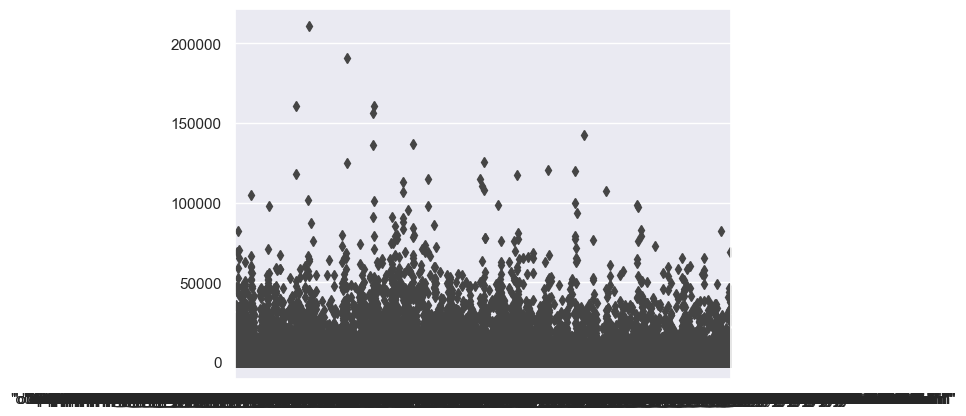

In [39]:
def box(df):
    cnames = list(df.columns)
    sns.boxplot(df[cnames])
    
box(df_HCC_s_cl)
box(df_MCF_s_cl)

In [40]:
print(np.where(df_HCC_s_cl>10000))

(array([  141,   141,   141, ..., 23331, 23331, 23338], dtype=int64), array([  1,   3,   6, ..., 224, 232,  62], dtype=int64))


---
## Extra violin plots, to keep?

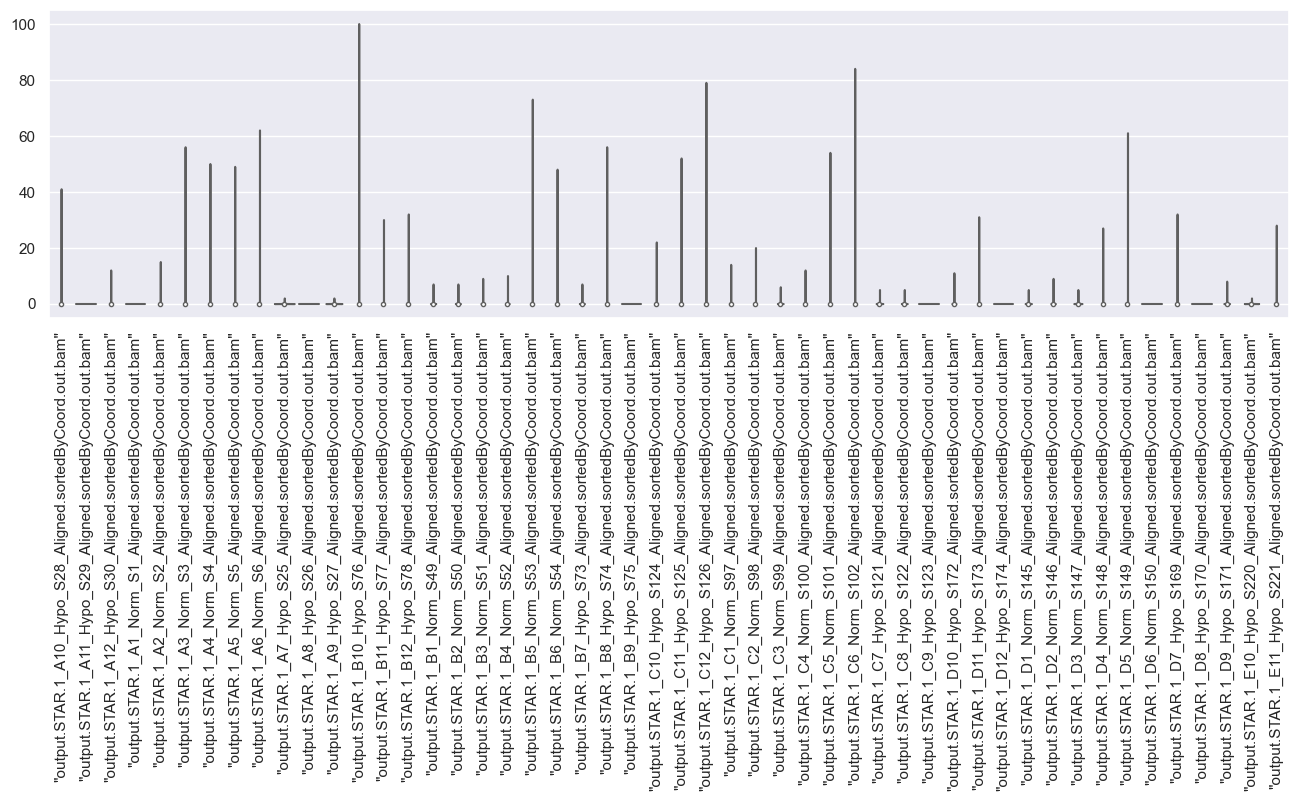

In [41]:
######
###### Should we keep this, Matt does not really see the point
######
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_MCF_noOut.iloc[:,:50],palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()



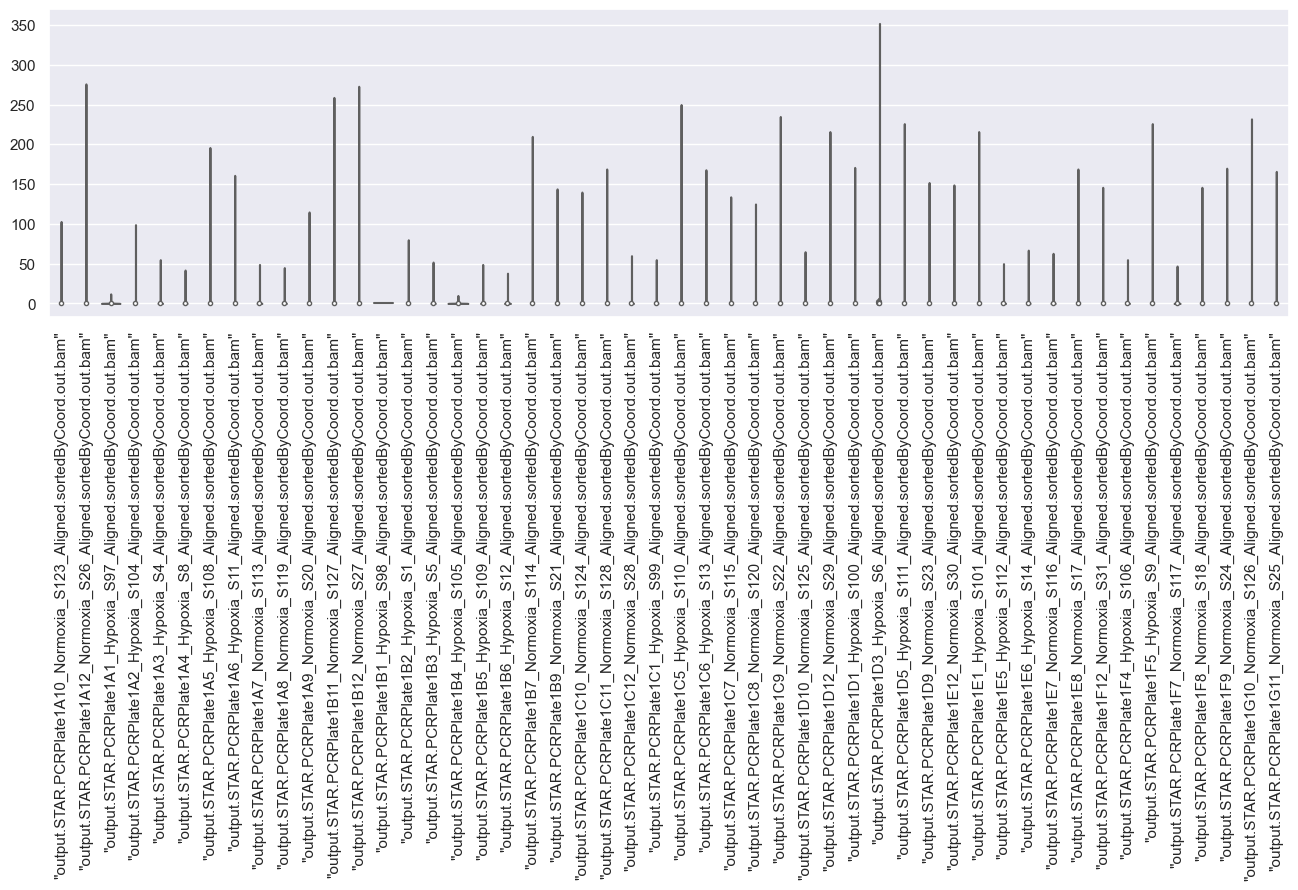

In [42]:
######
###### Should we keep this, Matt does not really see the point
######
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_HCC_noOut.iloc[:,:50],palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

---
---
# Data Transformation


## Distribution
In any dataset it is always useful to at least have an idea of what kind of distribiution does your data follow. While we will never know with certainty we can find some models that best approximate the data. Let's start with the Skewness of both our datasets.

In [43]:
#Skewness
from scipy.stats import skew

def skewness(df1, df2, title1 = '', title2 = ''):
  figure, ax = plt.subplots(1, 2, figsize=(12,6))
  cnames1 = list(df1.columns)
  cnames2 = list(df2.columns)
  colN1 = np.shape(df1)[1]
  colN2 = np.shape(df2)[1]
  df_skew_cells1 = []
  df_skew_cells2 = []

  for i in range(colN1) :     
      v_df1 = df1[cnames1[i]]
      df_skew_cells1 += [skew(v_df1)]
   
  for i in range(colN2):
     v_df2 = df2[cnames2[i]]
     df_skew_cells2 += [skew(v_df2)]

  #First graph 
  ax[0].hist(df_skew_cells1,bins=100)
  ax[0].set_title("Skewness of single cells for " + title1)

  #Second graph 
  ax[1].hist(df_skew_cells2,bins=100)
  ax[1].set_title("Skewness of single cells for " + title2)
  
  #plt.xlabel('Skewness of single cells expression profiles - original df')
  #print( "Skewness of normal distribution: ", skew(df_skew_cells) )



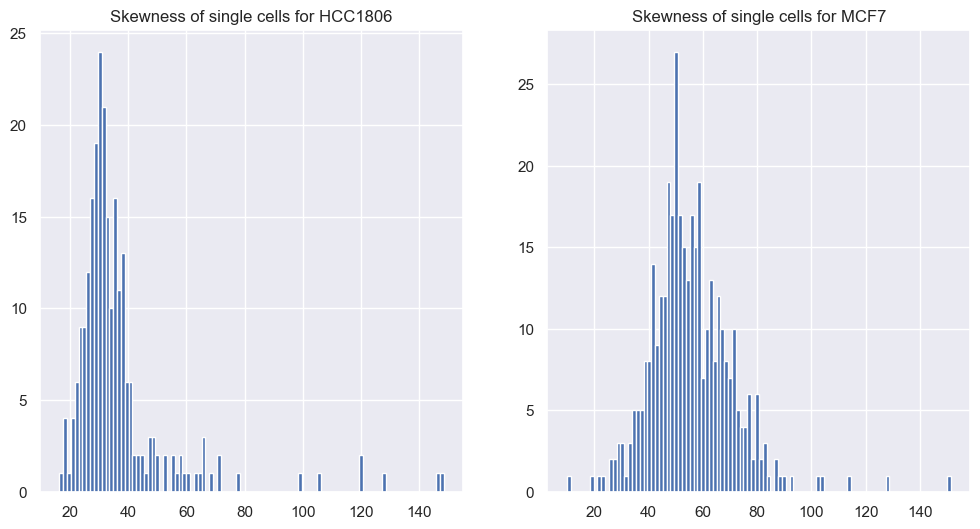

In [44]:
#Skewness of cells
skewness(df_HCC_s_uf, df_MCF_s_uf, title1="HCC1806", title2="MCF7")

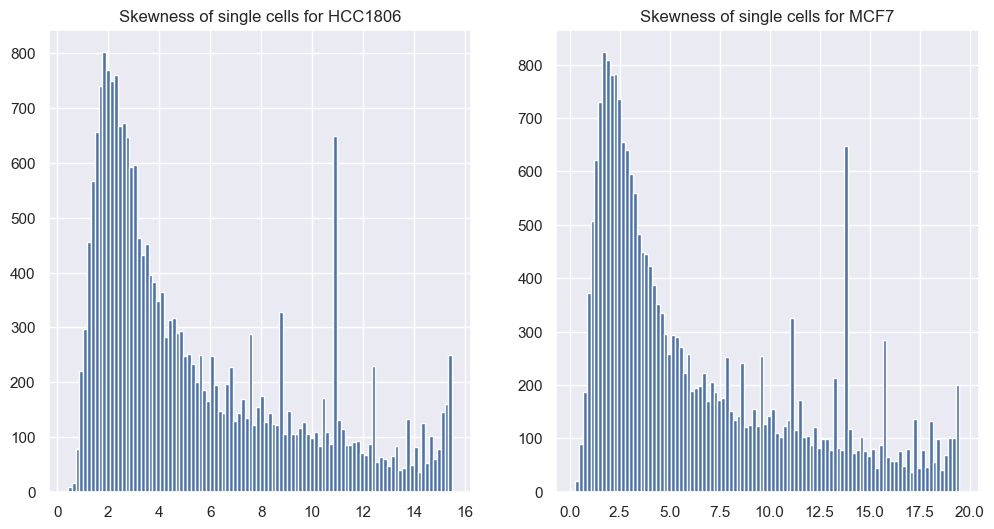

In [45]:
#Gene skewness
skewness(df_HCC_s_uf.T, df_MCF_s_uf.T, title1="HCC1806", title2="MCF7")

From the graphs above we see that the data has very large positive skew. This is exactly what we expect from our dataset, indeed we metioned before that we have a lot of entries which are zero in out datasets, this will lead to the mode (of a single cell) to be probably 0. The mean on the other hand will be very afected by the large values present in our columns (which can reach the order of 1e5) and the median will be somewhere between the two. In fact the Fisher-Pearson Coefficient (cancluated by `scripy.stats.skew`) when mode < median < mean will return a positive number. In our case the skewness is very drastic as our numbers can range in a very large interval.

In [46]:
#Kurtosis
from scipy.stats import kurtosis

def kurt(df1, df2, title1 = '', title2 = ''):
  figure, ax = plt.subplots(1, 2, figsize=(12,6))
  cnames1 = list(df1.columns)
  cnames2 = list(df2.columns)
  colN1 = np.shape(df1)[1]
  colN2 = np.shape(df2)[1]
  df_kurt_cells1 = []
  df_kurt_cells2 = []

  for i in range(colN1) :     
      v_df1 = df1[cnames1[i]]
      df_kurt_cells1 += [kurtosis(v_df1)]
   
  for i in range(colN2):
     v_df2 = df2[cnames2[i]]
     df_kurt_cells2 += [kurtosis(v_df2)]

  #First graph 
  ax[0].hist(df_kurt_cells1,bins=100)
  ax[0].set_title("Kurtosis of single cells for " + title1)

  #Second graph 
  ax[1].hist(df_kurt_cells2,bins=100)
  ax[1].set_title("Kurtosis of single cells for " + title2)


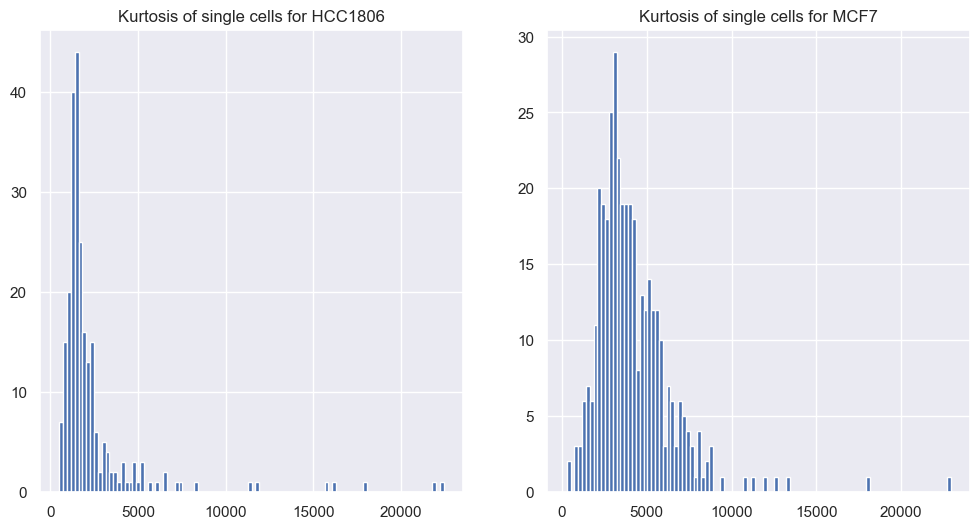

In [47]:
#Kurtosis for cell
kurt(df_HCC_s_uf, df_MCF_s_uf, title1="HCC1806", title2="MCF7")

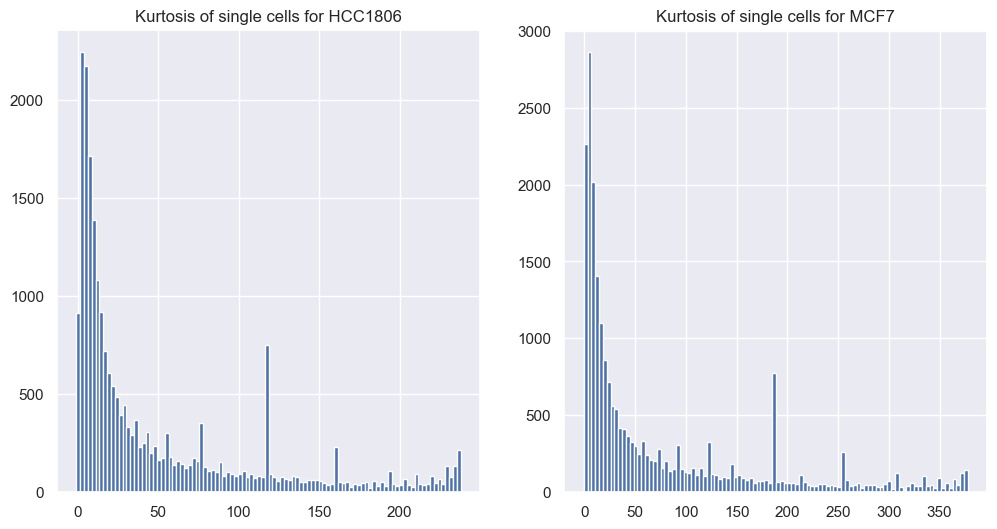

In [48]:
#Kurtosis for genes
kurt(df_HCC_s_uf.T, df_MCF_s_uf.T, title1="HCC1806", title2="MCF7")

This is what we expect
for single cell:
spike at zero and it falls off very quickly beacuse of the large values which means the kertosis will be very large compared to normal dist. There will be very high values due to the sparceness for the data.

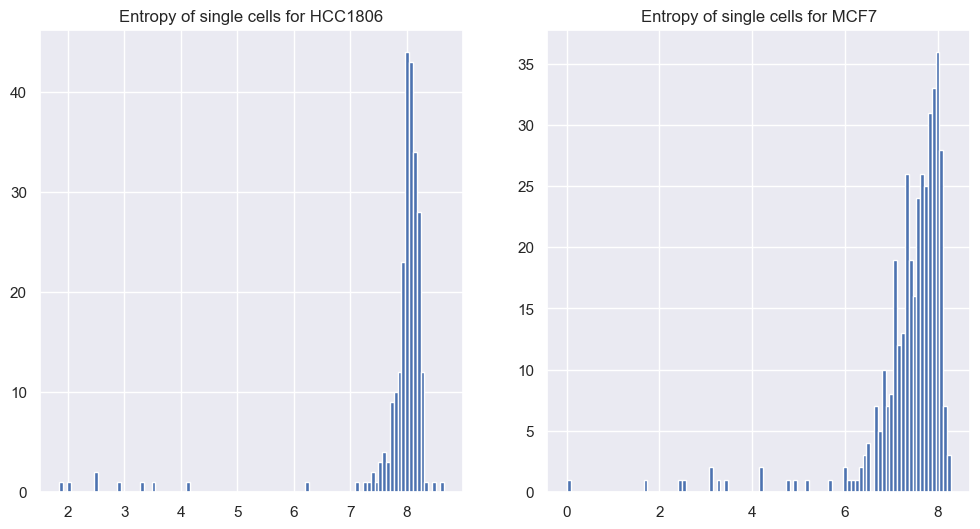

In [49]:
#Entropy
from scipy.stats import entropy

def entro(df1, df2, title1 = '', title2 = ''):
  figure, ax = plt.subplots(1, 2, figsize=(12,6))
  cnames1 = list(df1.columns)
  cnames2 = list(df2.columns)
  colN1 = np.shape(df1)[1]
  colN2 = np.shape(df2)[1]
  df_kurt_cells1 = []
  df_kurt_cells2 = []

  for i in range(colN1) :     
      v_df1 = df1[cnames1[i]]
      df_kurt_cells1 += [entropy(v_df1)]
   
  for i in range(colN2):
     v_df2 = df2[cnames2[i]]
     df_kurt_cells2 += [entropy(v_df2)]

  #First graph 
  ax[0].hist(df_kurt_cells1,bins=100)
  ax[0].set_title("Entropy of single cells for " + title1)

  #Second graph 
  ax[1].hist(df_kurt_cells2,bins=100)
  ax[1].set_title("Entropy of single cells for " + title2)
  
entro(df_HCC_s_uf, df_MCF_s_uf, title1="HCC1806", title2="MCF7")

The distribution are highly non-normal, skewed with heavy tails. Why is this a problem?

---
## Transform data

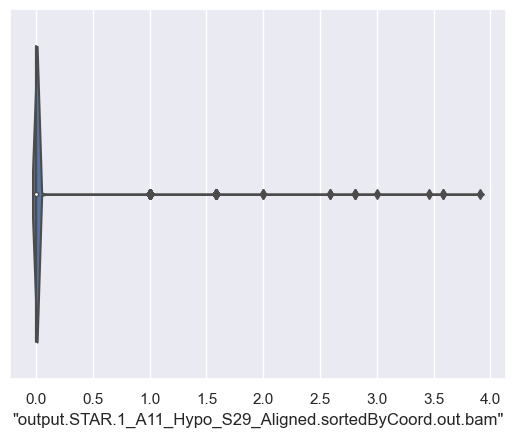

In [50]:
#Log transformation
def transform_log2(df):
    cnames = list(df.columns)
    df_log2 = np.log2(df[cnames[1]]+1)
    return df_log2


sns.boxplot(x=transform_log2(df_MCF_s_uf))
sns.violinplot(x=transform_log2(df_MCF_s_uf))
plt.show()

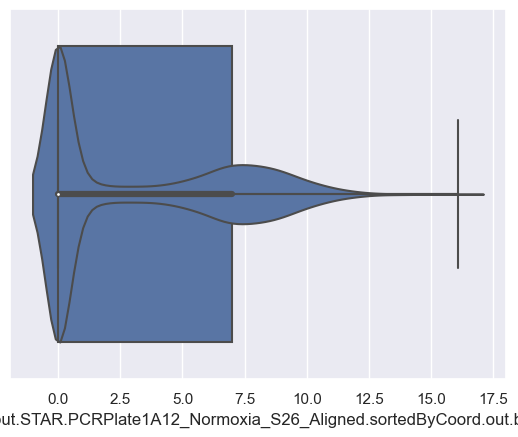

In [51]:
sns.boxplot(x=transform_log2(df_HCC_s_uf))
sns.violinplot(x=transform_log2(df_HCC_s_uf))
plt.show()

[None, None]

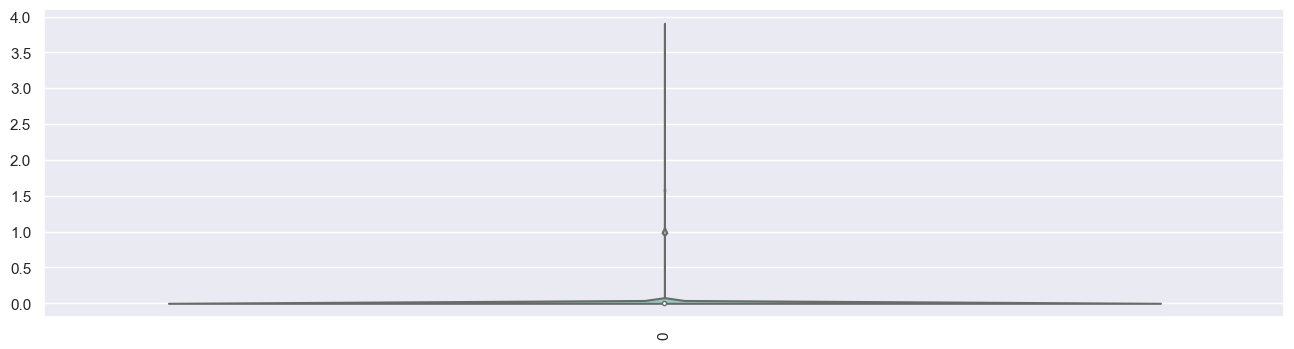

In [52]:
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=transform_log2(df_MCF_s_uf),palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

[None, None]

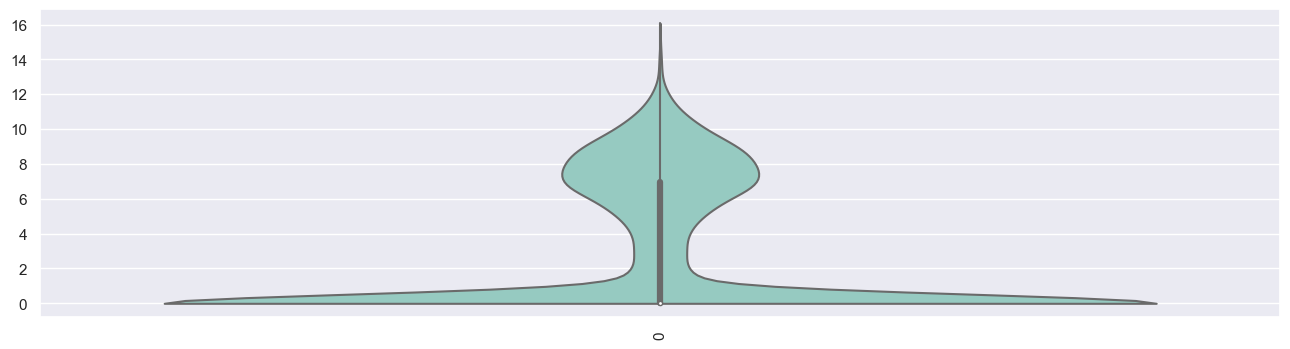

In [53]:
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=transform_log2(df_HCC_s_uf),palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

---
## Normalizing

In [54]:
def normed_data_graph(df):
    df_small = df.sample(frac=1, axis = 'columns').iloc[:, 10:30]  #just selecting part of the samples so run time not too long
    sns.displot(data=df_small,palette="Set3", kind="kde", bw_adjust=2)
    plt.show()


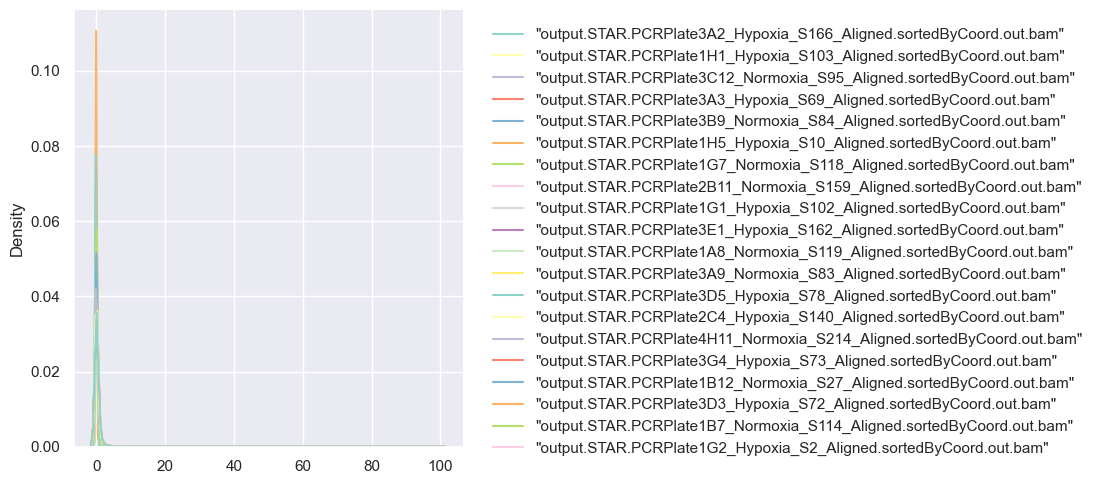

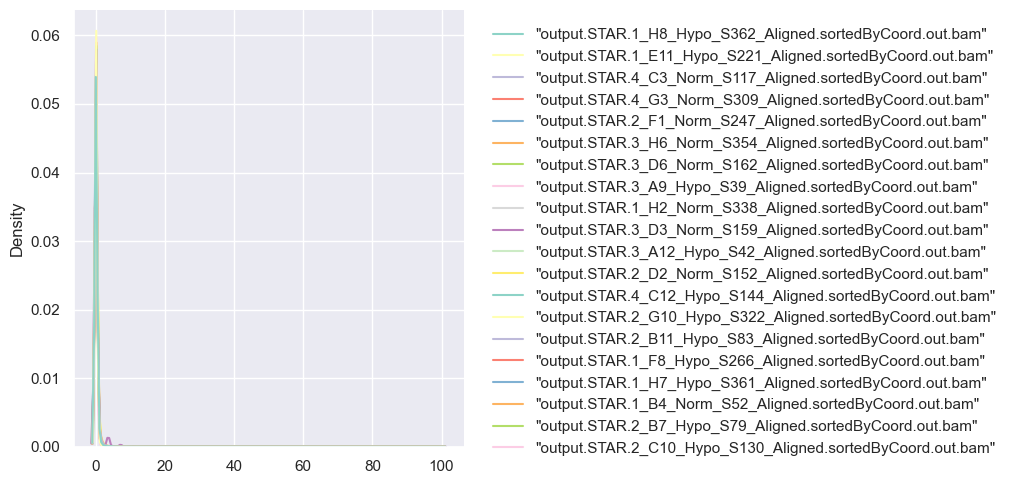

In [55]:
def min_max(df):
    df_norm = (df-df.min())/(df.max()-df.min()) * 100
    return df_norm

df_HCC_s_tr = min_max(df_HCC_s_uf)
df_MCF_s_tr = min_max(df_MCF_s_uf)
normed_data_graph(df_HCC_s_tr)
normed_data_graph(df_MCF_s_tr)

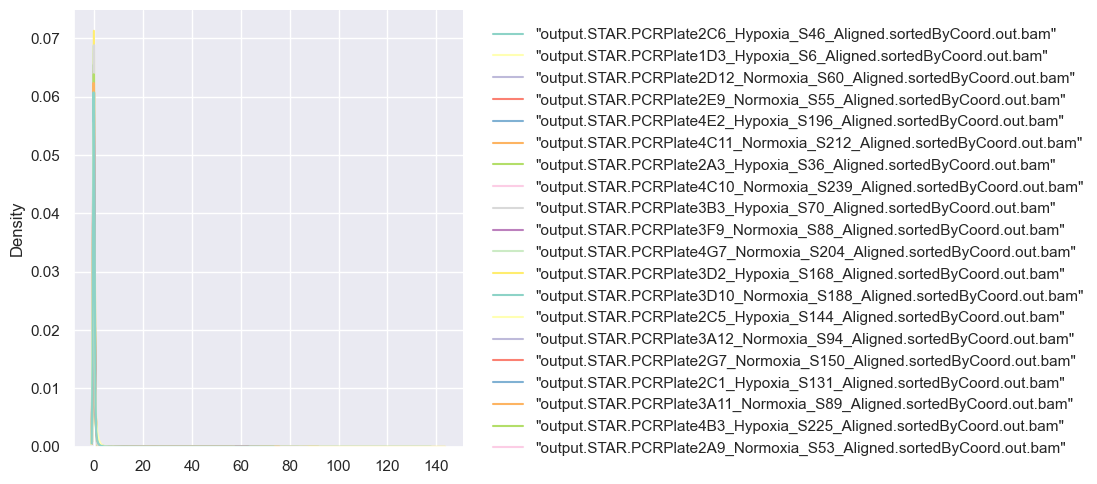

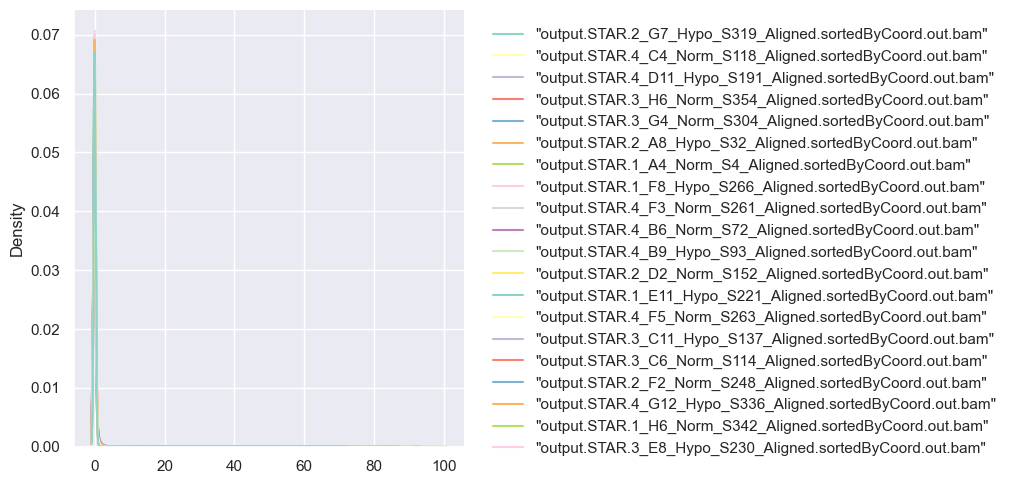

In [56]:
def z_score_scale(df):
    df_normed = normalized_df=(df-df.mean())/df.std()
    return df_normed

#We save the new data sets like df_XXX_s_tc (transfomred and cleared)
df_HCC_s_tc = z_score_scale(df_HCC_s_cl)
df_MCF_s_tc = z_score_scale(df_MCF_s_cl)
normed_data_graph(df_HCC_s_tc)
normed_data_graph(df_MCF_s_tc)

To visualize the distribution of each feature and to check that the data has been normalized correctly, we use a histogram representation. We expect the data to roughly follow a normal bell-shape, with a center at around 0.

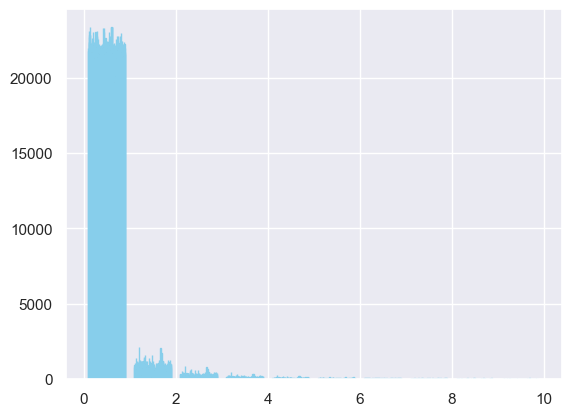

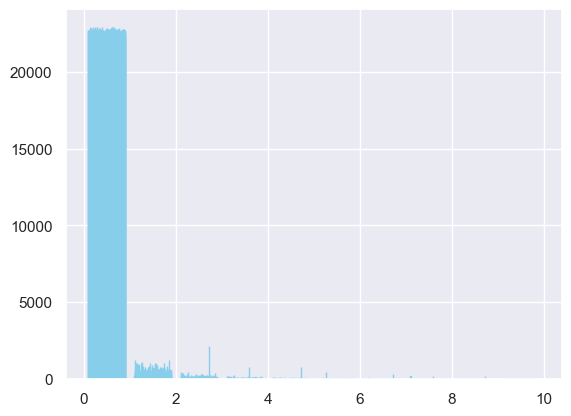

In [57]:
import matplotlib.pyplot as plt
def histnorm(df):
    plt.hist(x=df, range=[0, 10], ec = "skyblue")
    plt.show()
    
histnorm(df_HCC_s_tr)
histnorm(df_MCF_s_tr)

---
## Data Structure

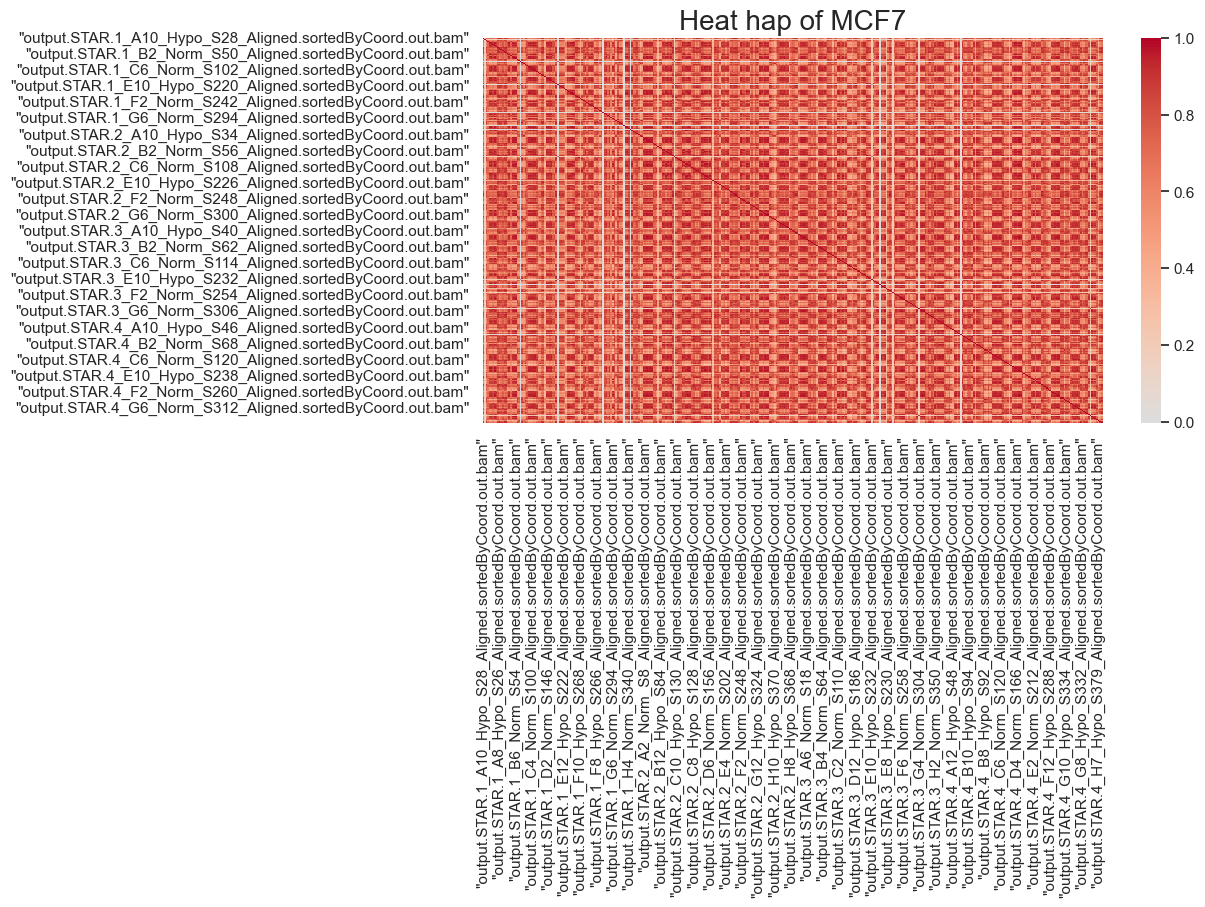

Number of cells included:  (383, 383)
Average correlation of expression profiles between cells:  0.49898217617448165
Min. correlation of expression profiles between cells:  -0.0020356476510366233


In [58]:
def heat_cor(df, title = ''):
    plt.figure(figsize=(10,5))
    c = df.corr()
    midpoint = (c.values.max() - c.values.min()) /2 + c.values.min()
    # sns.heatmap(c,cmap='coolwarm',annot=True, center=midpoint )
    # plt.show()
    sns.heatmap(c,cmap='coolwarm', center=0)
    plt.title("Heat hap of " + title, fontsize=20)
    plt.show()
    print("Number of cells included: ", np.shape(c))
    print("Average correlation of expression profiles between cells: ", midpoint)
    print("Min. correlation of expression profiles between cells: ", c.values.min())

heat_cor(df_MCF_s_tc, "MCF7")

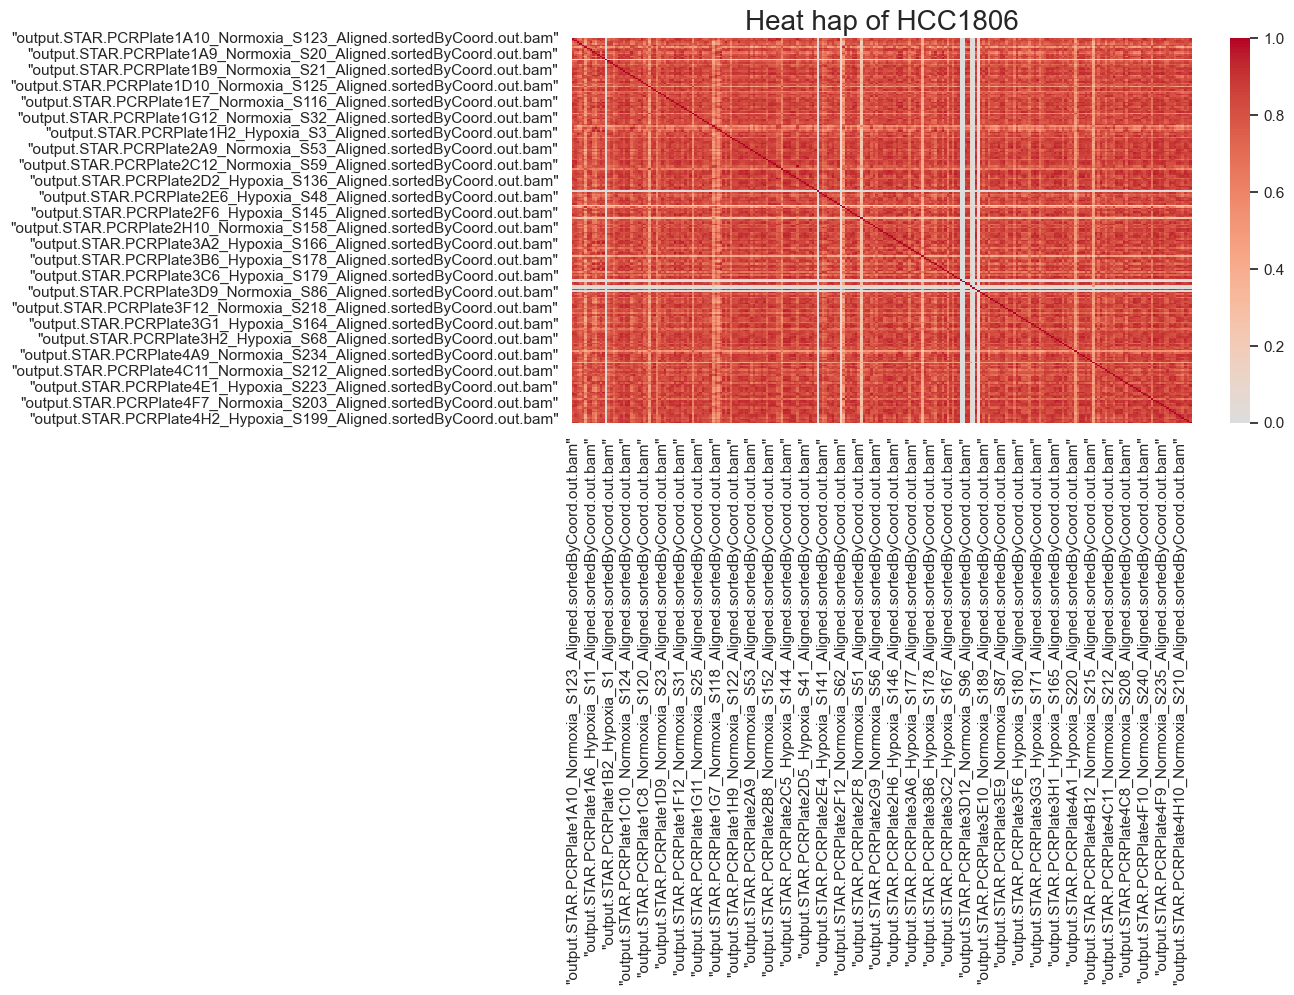

Number of cells included:  (243, 243)
Average correlation of expression profiles between cells:  0.4992910736551912
Min. correlation of expression profiles between cells:  -0.0014178526896174509


In [59]:
heat_cor(df_HCC_s_tc, title="HCC1806")

We could look at the distribution of the correlation between gene expression profiles using a histogram

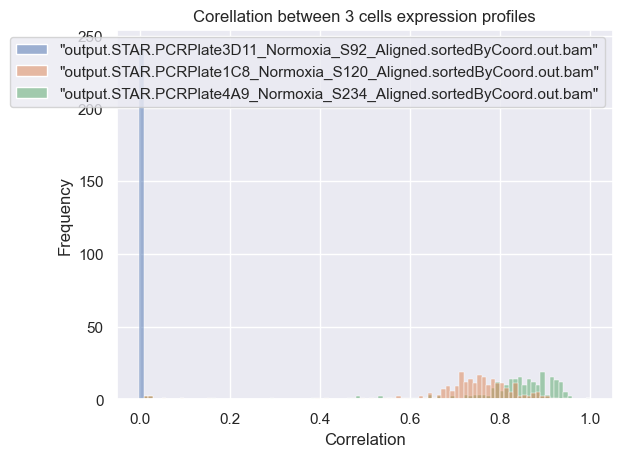

In [60]:
def hist_cor(df, title="", k = 3, rand=True, cells=None):
    #We take a small sample of the cells
    if cells is None: 
        c_small = df.corr().sample(n=k,axis='columns')
    else:
        c_small = df.corr().loc[:,cells[:3]]
    sns.histplot(c_small,bins=100)
    plt.title(f"Corellation between {k} cells expression profiles")
    plt.ylabel('Frequency')
    plt.xlabel('Correlation')
hist_cor(df_HCC_s_tc)

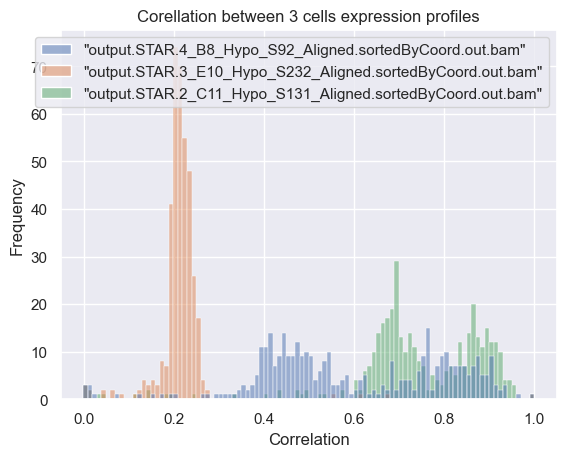

In [61]:
hist_cor(df_MCF_s_tc)

We expect that some genes are more frequent in hypoxia cells or in normoxia cells(in fact these are the cells that our classifiers will want to find!). Furthermore we expect that a large part of the genes have very high expression correlation amoung the other genes as these are what is called housekeeping genes and they do the basic functions for the cell to stay alive. By taking various samples we noticed that overall most of the correllations in the bar graph above are on the right side of 0.5. Let's now investigate the cells that do not follow this pattern.

We know thta some genes will be characteristic of some cells. For example in our case we expect some genes to be expressed at high levels only in cells cultured in conditions of low oxygen (hypoxia), or viceversa. However, most of the low and/or high expressed genes will tend to be generally similar. Several genes will have a high expression across cells as they are house keeping genes needed for the basic functioning of the cell. Some genes will have low expression across cells as they are less or not essential for the normal functioning, so they will have low or no expression across cells and will only be expressed in specific circumstances.

Are there some cells which are not correlated with the others?

Can you explore the distributions of gene expression for these cells and check why? Do they have more zero values than other cells?

Or do they have higher values?

Next you could explore the features/genes. Are they correlated? Is this expected? Could this generate issues in the ML?

Repeat the steps above for all datasets, and discuss the findings. We expect the correlation between the gene expression profiles of the the single cells to be fairly high.

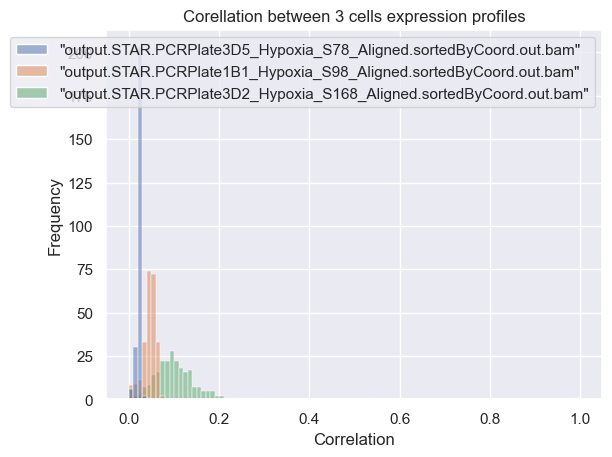

In [62]:
#Function that returns cells that have the lowest average correlation
def smallest_correlation(df, n=10):
    return list(df.corr().mean().nsmallest(n).index.values)

#Now lets plot the above histogram for three of these cells (for illustrative perposes we she the 4th, 5th and 6th smallest)
hist_cor(df_HCC_s_tc, cells=smallest_correlation(df_HCC_s_tc)[4:7])

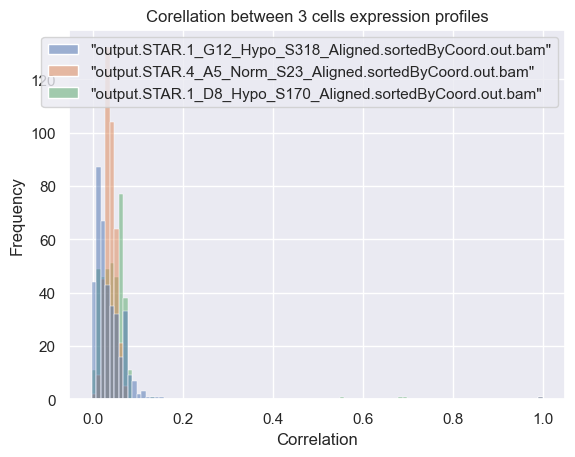

In [63]:
#Now lets plot the above histogram for three of these cells (for illustrative perposes we she the 4th, 5th and 6th smallest)
hist_cor(df_MCF_s_tc, cells=smallest_correlation(df_MCF_s_tc)[4:7])

Why are these cells so uncorrelated from the rest. Lets see how many zeros their columns have.

In [64]:
#Percentage of zeros in the very uncorrelated cells(we look at the original dataset as we already normalized this one)
print(f"Fraction of zeros in uncorellated cells: {round(frac_zeros(df_HCC_s_uf[smallest_correlation(df_HCC_s_tc)]),2)}%")

Fraction of zeros in uncorellated cells: 95.11%


In [65]:
#Percentage of zeros in the very uncorrelated cells(we look at the original dataset as we already normalized this one)
print(f"Fraction of zeros in uncorellated cells: {round(frac_zeros(df_MCF_s_uf[smallest_correlation(df_MCF_s_tc)]),2)}%")

Fraction of zeros in uncorellated cells: 96.51%


A lot of zeros!!

---
## Data transformation conlusion 

In the end...

---
### Comparing 

# Train-Test Split

The next section focuses on splitting the datasets in train and test sets, in order to perform our model and evaluate it.


## Additional Imports


In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [67]:
#Transposition
df_HCC_F = df_HCC_s_f.T
df_MCF_F = df_MCF_s_f.T
df_HCC_F.head()

"CICP27"  "DDX11L17"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...         0           0   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....         0           0   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...         0           0   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...         0           0   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...         0           1   

                                                    "WASH9P"  "OR4F29"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...         0         2   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....         0         0   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...         0         0   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...         0         0   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...         0         0   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...         250          54   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....         424         100   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...          63          16   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...          27           3   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...          81           1   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...        1740           6   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....        2340           5   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...        1020           3   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...         303           0   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...         587           0   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...           1         974   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....           1        1642   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...           0         653   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...           0          91   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...           0         161   

                                                    ...  "MT-TH"  "MT-TS2"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  ...       17         5   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  ...       49        29   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  ...       43        17   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  ...        0         0   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...  ...        1         0   

                                                    "MT-TL2"  "MT-ND5"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...        15      3852   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....        36      7457   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...         8      1479   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...         3       303   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...         0       650   

                                                    "MT-ND6"  "MT-TE"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...       900       22   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....      1439       43   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...       234        0   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...        33        0   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...        79        3   

                                                    "MT-CYB"  "MT-TT"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...      4208       26   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....      6491       62   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...      4819       11   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...       310        4   
"output.STAR.PCRPlate1A4_

---
## Pipeline Definition and Application

We define a generic pipeline to apply to the two datasets: 

(((In case additional scalers need to be applied, add the import in the section above and add the corresponding tuple in the list below.)))

In [68]:
steps = [('scaler', StandardScaler()), ('normalizer', MinMaxScaler())]
pipeline = Pipeline(steps)

In [69]:
df_HCC_F_N = pd.DataFrame(pipeline.fit_transform(df_HCC_F), columns=df_HCC_F.columns, index=df_HCC_F.index)
df_MCF_F_N = pd.DataFrame(pipeline.fit_transform(df_MCF_F), columns=df_MCF_F.columns, index=df_MCF_F.index)
df_HCC_F_N.head()

"CICP27"  "DDX11L17"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...       0.0    0.000000   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....       0.0    0.000000   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...       0.0    0.000000   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...       0.0    0.000000   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...       0.0    0.083333   

                                                    "WASH9P"  "OR4F29"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...       0.0       0.5   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....       0.0       0.0   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...       0.0       0.0   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...       0.0       0.0   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...       0.0       0.0   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...    0.359307    0.450000   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....    0.610390    0.833333   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...    0.089466    0.133333   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...    0.037518    0.025000   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...    0.115440    0.008333   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...    0.486813    0.500000   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....    0.655163    0.416667   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...    0.284792    0.250000   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...    0.083614    0.000000   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...    0.163300    0.000000   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...        0.25    0.412065   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....        0.25    0.695837   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...        0.00    0.275701   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...        0.00    0.036958   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...        0.00    0.066695   

                                                    ...   "MT-TH"  "MT-TS2"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  ...  0.326923  0.116279   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  ...  0.942308  0.674419   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  ...  0.826923  0.395349   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  ...  0.000000  0.000000   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...  ...  0.019231  0.000000   

                                                    "MT-TL2"  "MT-ND5"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  0.263158  0.428189   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  0.631579  0.830802   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  0.140351  0.163167   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  0.052632  0.031829   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...  0.000000  0.070583   

                                                    "MT-ND6"   "MT-TE"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  0.624128  0.103774   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  1.000000  0.202830   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  0.159693  0.000000   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  0.019526  0.000000   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...  0.051604  0.014151   

                                                    "MT-CYB"   "MT-TT"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  0.365044  0.168831   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  0.567080  0.402597   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  0.419115  0.071429   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  0.020088  0.025974   
"output.

---
## Main Genes Selection

In order to limit the dimension of the dataset, it is best to pick only 3000 genes for each dataset. The genes will be sorted with respect to a certain criteria (for now number of cells in which it is expressed)(??), and then the first 3000 columns in the dataset will be picked.

In [70]:
def MainCols(df,n):
    #Given Dataframe df and number n, returns the first n columns of df in term of nonzero elements
    non_zero_counts = pd.DataFrame((df != 0).sum(axis=0), columns = ["Counts"]).T
    sorted_df = non_zero_counts.sort_values(by = 'Counts', axis = 1, ascending = False)
    columns = (sorted_df.iloc[:,0:n]).columns
    filtered = df.loc[:, df.columns.isin(columns)]
    return filtered
    

In [71]:
df_HCC = MainCols(df_HCC_F_N, 3000)
df_MCF = MainCols(df_MCF_F_N, 3000)
df_HCC.head()

"MTND1P23"  "MTND2P28"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...    0.359307    0.450000   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....    0.610390    0.833333   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...    0.089466    0.133333   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...    0.037518    0.025000   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...    0.115440    0.008333   

                                                    "MTCO1P12"  "MTATP6P1"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...    0.486813    0.412065   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....    0.655163    0.695837   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...    0.284792    0.275701   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...    0.083614    0.036958   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...    0.163300    0.066695   

                                                    "MTCO3P12"   "ISG15"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...    0.345992  0.044321   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....    0.763713  0.155298   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...    0.295359  0.159107   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...    0.042194  0.021814   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...    0.075949  0.042763   

                                                      "SDF4"  "UBE2J2"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  0.118367  0.183635   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  0.298776  0.282588   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  0.347755  0.813511   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  0.083265  0.056137   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...  0.245714  0.016175   

                                                     "PUSL1"  "INTS11"  ...  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  0.002770  0.083770  ...   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  0.144044  0.352531  ...   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  0.024931  0.513089  ...   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  0.078947  0.055846  ...   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...  0.076177  0.152705  ...   

                                                    "MT-ATP8"  "MT-ATP6"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...   0.545094   0.431119   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....   0.862167   0.734575   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...   0.295519   0.317658   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...   0.014748   0.033612   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...   0.030630   0.072905   

                                                    "MT-CO3"  "MT-ND3"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  0.341359     0.455   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  0.634929     0.290   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  0.253352     0.000   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  0.030461     0.025   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...  0.062107     0.060   

                                                    "MT-ND4L"  "MT-ND4"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...   0.787973  0.851850   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....   0.556423  0.750157   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...   0.139269  0.314246   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...   0.035533  0.046022   
"output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sor...   0.072237  0.081721   

                                                    "MT-ND5"  "MT-ND6"  \
"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...  0.428189  0.624128   
"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....  0.830802  1.000000   
"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...  0.163167  0.159693   
"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...  0.031829  0.019526   
"output.STAR.P

---
## Split

This function splits the datasets into train and test, according to a ratio that we set.

(((I just write the function defined in page 49 of Lucibello's book)))

In [72]:
def split_train_test(data, test_ratio):
 shuffled_indices = np.random.permutation(len(data))
 test_set_size = int(len(data) * test_ratio)
 test_indices = shuffled_indices[:test_set_size]
 train_indices = shuffled_indices[test_set_size:]
 return data.iloc[train_indices], data.iloc[test_indices]

In [73]:
df_HCC_train , df_HCC_test = split_train_test(df_HCC, 0.2)
df_MCF_train , df_MCF_test = split_train_test(df_MCF, 0.2)

In [74]:
df_HCC_train.head()

"MTND1P23"  "MTND2P28"  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...    0.209235    0.358333   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...    0.223665    0.258333   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....    0.023088    0.025000   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...    0.264069    0.600000   
"output.STAR.PCRPlate4B12_Normoxia_S215_Aligned...    0.092352    0.133333   

                                                    "MTCO1P12"  "MTATP6P1"  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...    0.262065    0.220051   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...    0.222783    0.181818   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....    0.052189    0.070093   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...    0.541246    0.765930   
"output.STAR.PCRPlate4B12_Normoxia_S215_Aligned...    0.302750    0.324554   

                                                    "MTCO3P12"   "ISG15"  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...    0.198312  0.027874   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...    0.080169  0.035838   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....    0.135021  0.014543   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...    0.654008  0.081025   
"output.STAR.PCRPlate4B12_Normoxia_S215_Aligned...    0.227848  0.033068   

                                                      "SDF4"  "UBE2J2"  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...  0.272653  0.178877   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...  0.280816  0.176023   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....  0.000000  0.013321   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...  0.140408  0.344434   
"output.STAR.PCRPlate4B12_Normoxia_S215_Aligned...  0.187755  0.111323   

                                                     "PUSL1"  "INTS11"  ...  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...  0.353186  0.326353  ...   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...  0.217452  0.359511  ...   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....  0.000000  0.000000  ...   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...  0.397507  0.168412  ...   
"output.STAR.PCRPlate4B12_Normoxia_S215_Aligned...  0.447368  0.240838  ...   

                                                    "MT-ATP8"  "MT-ATP6"  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...   0.341463   0.231655   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...   0.183210   0.161748   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....   0.081112   0.074483   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...   0.906410   0.782863   
"output.STAR.PCRPlate4B12_Normoxia_S215_Aligned...   0.407260   0.301878   

                                                    "MT-CO3"  "MT-ND3"  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...  0.194437     0.215   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...  0.132604     0.115   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....  0.098039     0.070   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...  0.668582     0.115   
"output.STAR.PCRPlate4B12_Normoxia_S215_Aligned...  0.200912     0.125   

                                                    "MT-ND4L"  "MT-ND4"  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...   0.168944  0.189638   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...   0.250553  0.182353   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....   0.063257  0.096290   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...   0.508916  0.582373   
"output.STAR.PCRPlate4B12_Normoxia_S215_Aligned...   0.182871  0.218197   

                                                    "MT-ND5"  "MT-ND6"  \
"output.STAR.PCRPlate4F12_Normoxia_S242_Aligned...  0.203596  0.276151   
"output.STAR.PCRPlate3H7_Normoxia_S81_Aligned.s...  0.197230  0.170851   
"output.STAR.PCRPlate2D12_Normoxia_S60_Aligned....  0.084096  0.090656   
"output.STAR.PCRPlate1B11_Normoxia_S127_Aligned...  0.473308  0.466527   
"output.STAR.P

---
## Labels

Create four dataframes containing only one column: the label hypoxia-normoxia is encoded as 0-1.

In [75]:
# def Label(df, meta):
#     Names = [cell[1:-1] for cell in df.index]
#     Hypo = [meta.loc[i,"Condition"] for i in Names]
#     OH_Hypo = [1 if x=="Normo" else 0 for x in Hypo]
#     result = pd.DataFrame(OH_Hypo, columns=["Condition"], index=df.index)
#     return result

#Given a dataset it returns a list will all the values of the targets (hypo = 0 and Norm = 1)
def labels(df):
    target = []
    for c in df.columns:
        if "Hypoxia" in c.replace('\"', '').split("_") or "Hypo" in c.split("_"):
            target.append(0.0)
        elif "Normoxia" in c.replace('\"', '').split("_") or "Norm" in c.split("_"):
            target.append(1.0)
        else:
            print(c)
            raise ValueError("Cell cannot be categorized")
    return target

In [76]:
Y_HCC_train = labels(df_HCC_train.T)
Y_HCC_test = labels(df_HCC_test.T)
Y_MCF_train = labels(df_MCF_train.T)
Y_MCF_test = labels(df_MCF_test.T)

---
---

In [77]:
# import csv
# display(df_HCC_train.T)
# display(df_HCC_test.T)
# display(df_MCF_train.T)
# display(df_MCF_test.T)
# df_HCC_train.T.to_csv("./processed_data/HCC1806_SmartS_Filtered_Standardized-Normalised_3000_Data_train.txt", sep=" ", quoting=csv.QUOTE_NONE)
# df_HCC_test.T.to_csv("./processed_data/HCC1806_SmartS_Filtered_Standardized-Normalised_3000_Data_test.txt", sep=" ", quoting=csv.QUOTE_NONE)
# df_MCF_train.T.to_csv("./processed_data/MCF7_SmartS_Filtered_Standardized-Normalised_3000_Data_train.txt", sep=" ", quoting=csv.QUOTE_NONE)
# df_MCF_test.T.to_csv("./processed_data/MCF7_SmartS_Filtered_Standardized-Normalised_3000_Data_test.txt", sep=" ", quoting=csv.QUOTE_NONE)

# Models


---
# Logistic Regression

We start by importing out new processed datasets

In [78]:
#-----SmartSeq-----#
HCC_s_Train = pd.read_csv("processed_data\HCC1806_SmartS_Filtered_Standardized-Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0)
MCF_s_Train = pd.read_csv("processed_data\MCF7_SmartS_Filtered_Standardized-Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0)
HCC_s_Test = pd.read_csv("processed_data\HCC1806_SmartS_Filtered_Standardized-Normalised_3000_Data_test.txt", delimiter="\ ",engine='python',index_col=0)
MCF_s_Test = pd.read_csv("processed_data\MCF7_SmartS_Filtered_Standardized-Normalised_3000_Data_test.txt", delimiter="\ ",engine='python',index_col=0)

#-----DropSeq-----#
HCC_d = pd.read_csv("raw_data_DropSeq\HCC1806_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0)
MCF_d = pd.read_csv("raw_data_DropSeq\MCF7_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0)


In [79]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def logi_model(df, y):
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    model = pipe.fit(df.T, y)
    return model

#-----SmartSeq-----#
HCC_s_logi_model = logi_model(HCC_s_Train, labels(HCC_s_Train))
MCF_s_logi_model = logi_model(MCF_s_Train, labels(MCF_s_Train))

#-----DropSeq-----#
HCC_d_train, HCC_d_test, y_HCC_d_train, y_HCC_d_test = train_test_split(HCC_d.T, labels(HCC_d))
MCF_d_train, MCF_d_test, y_MCF_d_train, y_MCF_d_test = train_test_split(MCF_d.T, labels(MCF_d))
HCC_d_logi_model = logi_model(HCC_d_train.T, y_HCC_d_train)
MCF_d_logi_model = logi_model(MCF_d_train.T, y_MCF_d_train)


# Perfromance Measures

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
warnings.simplefilter('ignore')

def cv_score(df, model):
    scaler = StandardScaler()
    return cross_val_score(model, scaler.fit_transform(df.T), labels(df), cv=KFold(shuffle=True, n_splits=5), scoring="accuracy")

#-----SmartSeq-----#
print("Cross validation score: ", cv_score(HCC_s_Train, HCC_s_logi_model))
print("Cross validation score: ", cv_score(MCF_s_Train, MCF_s_logi_model))

#-----DropSeq-----#
print("Cross validation score: ", cv_score(HCC_d_train.T, HCC_d_logi_model))
print("Cross validation score: ", cv_score(MCF_d_train.T, MCF_d_logi_model))

Cross validation score:  [0.97297297 0.94594595 0.91666667 1.         0.97222222]
Cross validation score:  [1. 1. 1. 1. 1.]
Cross validation score:  [0.91466182 0.92461399 0.91280654 0.9191644  0.91961853]
Cross validation score:  [0.96454994 0.96578298 0.96578298 0.96454994 0.96700586]


In [81]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def pred_accuracy(df, model, title=""):
    print(title)
    print("Score: ", model.score(df.T, y=labels(df)))
    #print("Accuracy Score: ", accuracy_score(labels(df),model.predict(df.T)))
    print("Confusion matrix: \n", confusion_matrix(model.predict(df.T), labels(df)), "\n")

#-----SmartSeq-----#
pred_accuracy(HCC_s_Test, HCC_s_logi_model, "SmartSeq HCC:")
pred_accuracy(MCF_s_Test, MCF_s_logi_model, "SmartSeq MCF:")

#-----DropSeq-----#
pred_accuracy(HCC_d_test.T, HCC_d_logi_model, "DropSeq HCC:")
pred_accuracy(MCF_d_test.T, MCF_d_logi_model, "DropSeq MCF:")


SmartSeq HCC:
Score:  0.9555555555555556
Confusion matrix: 
 [[18  2]
 [ 0 25]] 

SmartSeq MCF:
Score:  0.9838709677419355
Confusion matrix: 
 [[29  1]
 [ 0 32]] 

DropSeq HCC:
Score:  0.9212748569871969
Confusion matrix: 
 [[2055  122]
 [ 167 1327]] 

DropSeq MCF:
Score:  0.9624560754577399
Confusion matrix: 
 [[2195  106]
 [  97 3009]] 

